In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 474)
(3944610, 8)
validation
(464344, 474)
(464344, 8)
test
(574820, 474)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 474)]             0         


 dense (Dense)               (None, 1024)              486400    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1176456 (4.49 MB)


Trainable params: 1176456 (4.49 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 7:58 - loss: 2.4943 - STD: 0.1068 - MAE: 0.2206

  5/395 [..............................] - ETA: 4s - loss: 2.1980 - STD: 0.0612 - MAE: 0.2180  

  9/395 [..............................] - ETA: 4s - loss: 2.1502 - STD: 0.0628 - MAE: 0.2166

 13/395 [..............................] - ETA: 4s - loss: 2.1301 - STD: 0.0564 - MAE: 0.2167

 17/395 [>.............................] - ETA: 4s - loss: 2.1136 - STD: 0.0500 - MAE: 0.2168

 21/395 [>.............................] - ETA: 4s - loss: 2.1020 - STD: 0.0470 - MAE: 0.2168

 25/395 [>.............................] - ETA: 4s - loss: 2.0953 - STD: 0.0456 - MAE: 0.2167

 30/395 [=>............................] - ETA: 4s - loss: 2.0882 - STD: 0.0435 - MAE: 0.2167

 35/395 [=>............................] - ETA: 4s - loss: 2.0832 - STD: 0.0419 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 4s - loss: 2.0790 - STD: 0.0409 - MAE: 0.2167

 45/395 [==>...........................] - ETA: 4s - loss: 2.0762 - STD: 0.0402 - MAE: 0.2167

 49/395 [==>...........................] - ETA: 4s - loss: 2.0743 - STD: 0.0394 - MAE: 0.2167

 54/395 [===>..........................] - ETA: 4s - loss: 2.0722 - STD: 0.0385 - MAE: 0.2167

 58/395 [===>..........................] - ETA: 4s - loss: 2.0708 - STD: 0.0382 - MAE: 0.2167

 62/395 [===>..........................] - ETA: 4s - loss: 2.0695 - STD: 0.0378 - MAE: 0.2167

 66/395 [====>.........................] - ETA: 4s - loss: 2.0684 - STD: 0.0374 - MAE: 0.2167

 71/395 [====>.........................] - ETA: 4s - loss: 2.0673 - STD: 0.0370 - MAE: 0.2167

 76/395 [====>.........................] - ETA: 3s - loss: 2.0663 - STD: 0.0365 - MAE: 0.2167

 81/395 [=====>........................] - ETA: 3s - loss: 2.0652 - STD: 0.0363 - MAE: 0.2167

 86/395 [=====>........................] - ETA: 3s - loss: 2.0643 - STD: 0.0361 - MAE: 0.2167

 91/395 [=====>........................] - ETA: 3s - loss: 2.0634 - STD: 0.0357 - MAE: 0.2167

 96/395 [======>.......................] - ETA: 3s - loss: 2.0623 - STD: 0.0355 - MAE: 0.2167

100/395 [======>.......................] - ETA: 3s - loss: 2.0613 - STD: 0.0354 - MAE: 0.2167

105/395 [======>.......................] - ETA: 5s - loss: 2.0600 - STD: 0.0353 - MAE: 0.2166

110/395 [=======>......................] - ETA: 5s - loss: 2.0578 - STD: 0.0353 - MAE: 0.2166

115/395 [=======>......................] - ETA: 5s - loss: 2.0548 - STD: 0.0355 - MAE: 0.2165

120/395 [========>.....................] - ETA: 4s - loss: 2.0511 - STD: 0.0360 - MAE: 0.2163

125/395 [========>.....................] - ETA: 4s - loss: 2.0472 - STD: 0.0369 - MAE: 0.2161

130/395 [========>.....................] - ETA: 4s - loss: 2.0434 - STD: 0.0379 - MAE: 0.2160

135/395 [=========>....................] - ETA: 4s - loss: 2.0395 - STD: 0.0389 - MAE: 0.2157

140/395 [=========>....................] - ETA: 4s - loss: 2.0357 - STD: 0.0398 - MAE: 0.2156

145/395 [==========>...................] - ETA: 4s - loss: 2.0323 - STD: 0.0406 - MAE: 0.2154

150/395 [==========>...................] - ETA: 4s - loss: 2.0288 - STD: 0.0414 - MAE: 0.2152

155/395 [==========>...................] - ETA: 3s - loss: 2.0255 - STD: 0.0422 - MAE: 0.2150

160/395 [===========>..................] - ETA: 3s - loss: 2.0221 - STD: 0.0429 - MAE: 0.2149

165/395 [===========>..................] - ETA: 3s - loss: 2.0188 - STD: 0.0436 - MAE: 0.2147

170/395 [===========>..................] - ETA: 3s - loss: 2.0155 - STD: 0.0443 - MAE: 0.2145

175/395 [============>.................] - ETA: 3s - loss: 2.0123 - STD: 0.0449 - MAE: 0.2143

180/395 [============>.................] - ETA: 3s - loss: 2.0088 - STD: 0.0457 - MAE: 0.2141

185/395 [=============>................] - ETA: 3s - loss: 2.0053 - STD: 0.0465 - MAE: 0.2139

190/395 [=============>................] - ETA: 3s - loss: 2.0017 - STD: 0.0474 - MAE: 0.2137

195/395 [=============>................] - ETA: 3s - loss: 1.9983 - STD: 0.0483 - MAE: 0.2135

200/395 [==============>...............] - ETA: 3s - loss: 1.9950 - STD: 0.0492 - MAE: 0.2132

205/395 [==============>...............] - ETA: 2s - loss: 1.9918 - STD: 0.0500 - MAE: 0.2130

210/395 [==============>...............] - ETA: 2s - loss: 1.9884 - STD: 0.0508 - MAE: 0.2128

215/395 [===============>..............] - ETA: 2s - loss: 1.9851 - STD: 0.0516 - MAE: 0.2126

220/395 [===============>..............] - ETA: 2s - loss: 1.9818 - STD: 0.0524 - MAE: 0.2124

225/395 [================>.............] - ETA: 2s - loss: 1.9784 - STD: 0.0532 - MAE: 0.2122

230/395 [================>.............] - ETA: 2s - loss: 1.9751 - STD: 0.0540 - MAE: 0.2120

235/395 [================>.............] - ETA: 2s - loss: 1.9717 - STD: 0.0547 - MAE: 0.2117

240/395 [=================>............] - ETA: 2s - loss: 1.9681 - STD: 0.0555 - MAE: 0.2115

245/395 [=================>............] - ETA: 2s - loss: 1.9647 - STD: 0.0563 - MAE: 0.2113

250/395 [=================>............] - ETA: 2s - loss: 1.9612 - STD: 0.0570 - MAE: 0.2111

255/395 [==================>...........] - ETA: 2s - loss: 1.9579 - STD: 0.0578 - MAE: 0.2108

260/395 [==================>...........] - ETA: 1s - loss: 1.9548 - STD: 0.0585 - MAE: 0.2106

265/395 [===================>..........] - ETA: 1s - loss: 1.9516 - STD: 0.0592 - MAE: 0.2104

270/395 [===================>..........] - ETA: 1s - loss: 1.9484 - STD: 0.0599 - MAE: 0.2102

275/395 [===================>..........] - ETA: 1s - loss: 1.9453 - STD: 0.0606 - MAE: 0.2100

280/395 [====================>.........] - ETA: 1s - loss: 1.9423 - STD: 0.0613 - MAE: 0.2098

285/395 [====================>.........] - ETA: 1s - loss: 1.9392 - STD: 0.0620 - MAE: 0.2096

289/395 [====================>.........] - ETA: 1s - loss: 1.9369 - STD: 0.0625 - MAE: 0.2094

294/395 [=====================>........] - ETA: 1s - loss: 1.9339 - STD: 0.0631 - MAE: 0.2092

299/395 [=====================>........] - ETA: 1s - loss: 1.9310 - STD: 0.0637 - MAE: 0.2091

304/395 [======================>.......] - ETA: 1s - loss: 1.9283 - STD: 0.0644 - MAE: 0.2089

309/395 [======================>.......] - ETA: 1s - loss: 1.9255 - STD: 0.0649 - MAE: 0.2087

314/395 [======================>.......] - ETA: 1s - loss: 1.9229 - STD: 0.0655 - MAE: 0.2085

319/395 [=======================>......] - ETA: 1s - loss: 1.9203 - STD: 0.0661 - MAE: 0.2083

324/395 [=======================>......] - ETA: 1s - loss: 1.9177 - STD: 0.0667 - MAE: 0.2081

329/395 [=======================>......] - ETA: 0s - loss: 1.9151 - STD: 0.0672 - MAE: 0.2080

334/395 [========================>.....] - ETA: 0s - loss: 1.9125 - STD: 0.0678 - MAE: 0.2078

339/395 [========================>.....] - ETA: 0s - loss: 1.9101 - STD: 0.0683 - MAE: 0.2076

344/395 [=========================>....] - ETA: 0s - loss: 1.9076 - STD: 0.0689 - MAE: 0.2075

349/395 [=========================>....] - ETA: 0s - loss: 1.9052 - STD: 0.0694 - MAE: 0.2073

354/395 [=========================>....] - ETA: 0s - loss: 1.9030 - STD: 0.0699 - MAE: 0.2071

359/395 [==========================>...] - ETA: 0s - loss: 1.9007 - STD: 0.0703 - MAE: 0.2070

364/395 [==========================>...] - ETA: 0s - loss: 1.8983 - STD: 0.0708 - MAE: 0.2068

369/395 [===========================>..] - ETA: 0s - loss: 1.8959 - STD: 0.0713 - MAE: 0.2067

374/395 [===========================>..] - ETA: 0s - loss: 1.8937 - STD: 0.0718 - MAE: 0.2065

379/395 [===========================>..] - ETA: 0s - loss: 1.8914 - STD: 0.0723 - MAE: 0.2063

384/395 [============================>.] - ETA: 0s - loss: 1.8893 - STD: 0.0727 - MAE: 0.2062

389/395 [============================>.] - ETA: 0s - loss: 1.8871 - STD: 0.0732 - MAE: 0.2061

394/395 [============================>.] - ETA: 0s - loss: 1.8852 - STD: 0.0736 - MAE: 0.2059

395/395 [==============================] - 8s 16ms/step - loss: 1.8848 - STD: 0.0737 - MAE: 0.2059 - val_loss: 1.7160 - val_STD: 0.1004 - val_MAE: 0.1953


Epoch 2/10000


  1/395 [..............................] - ETA: 13s - loss: 1.7189 - STD: 0.1065 - MAE: 0.1949

  6/395 [..............................] - ETA: 5s - loss: 1.7207 - STD: 0.1078 - MAE: 0.1946 

 11/395 [..............................] - ETA: 4s - loss: 1.7150 - STD: 0.1080 - MAE: 0.1943

 16/395 [>.............................] - ETA: 4s - loss: 1.7116 - STD: 0.1089 - MAE: 0.1940

 21/395 [>.............................] - ETA: 4s - loss: 1.7091 - STD: 0.1091 - MAE: 0.1939

 26/395 [>.............................] - ETA: 4s - loss: 1.7065 - STD: 0.1095 - MAE: 0.1937

 31/395 [=>............................] - ETA: 4s - loss: 1.7049 - STD: 0.1099 - MAE: 0.1936

 36/395 [=>............................] - ETA: 4s - loss: 1.7029 - STD: 0.1101 - MAE: 0.1935

 41/395 [==>...........................] - ETA: 4s - loss: 1.7016 - STD: 0.1104 - MAE: 0.1934

 46/395 [==>...........................] - ETA: 4s - loss: 1.7024 - STD: 0.1109 - MAE: 0.1933

 51/395 [==>...........................] - ETA: 4s - loss: 1.7034 - STD: 0.1110 - MAE: 0.1933

 56/395 [===>..........................] - ETA: 4s - loss: 1.7035 - STD: 0.1112 - MAE: 0.1933

 61/395 [===>..........................] - ETA: 4s - loss: 1.7037 - STD: 0.1112 - MAE: 0.1933

 66/395 [====>.........................] - ETA: 3s - loss: 1.7032 - STD: 0.1113 - MAE: 0.1932

 71/395 [====>.........................] - ETA: 3s - loss: 1.7020 - STD: 0.1114 - MAE: 0.1932

 76/395 [====>.........................] - ETA: 3s - loss: 1.7011 - STD: 0.1116 - MAE: 0.1931

 81/395 [=====>........................] - ETA: 3s - loss: 1.7001 - STD: 0.1117 - MAE: 0.1930

 86/395 [=====>........................] - ETA: 3s - loss: 1.6986 - STD: 0.1119 - MAE: 0.1929

 91/395 [=====>........................] - ETA: 3s - loss: 1.6974 - STD: 0.1120 - MAE: 0.1929

 96/395 [======>.......................] - ETA: 3s - loss: 1.6965 - STD: 0.1122 - MAE: 0.1928

101/395 [======>.......................] - ETA: 3s - loss: 1.6956 - STD: 0.1125 - MAE: 0.1927

106/395 [=======>......................] - ETA: 3s - loss: 1.6944 - STD: 0.1126 - MAE: 0.1926

111/395 [=======>......................] - ETA: 3s - loss: 1.6937 - STD: 0.1127 - MAE: 0.1926

116/395 [=======>......................] - ETA: 3s - loss: 1.6927 - STD: 0.1130 - MAE: 0.1925

121/395 [========>.....................] - ETA: 3s - loss: 1.6914 - STD: 0.1132 - MAE: 0.1924

126/395 [========>.....................] - ETA: 3s - loss: 1.6903 - STD: 0.1133 - MAE: 0.1923

131/395 [========>.....................] - ETA: 3s - loss: 1.6895 - STD: 0.1135 - MAE: 0.1923

136/395 [=========>....................] - ETA: 3s - loss: 1.6884 - STD: 0.1136 - MAE: 0.1922

141/395 [=========>....................] - ETA: 3s - loss: 1.6873 - STD: 0.1137 - MAE: 0.1921

146/395 [==========>...................] - ETA: 2s - loss: 1.6862 - STD: 0.1139 - MAE: 0.1920

151/395 [==========>...................] - ETA: 2s - loss: 1.6856 - STD: 0.1141 - MAE: 0.1920

156/395 [==========>...................] - ETA: 2s - loss: 1.6854 - STD: 0.1143 - MAE: 0.1919

161/395 [===========>..................] - ETA: 2s - loss: 1.6849 - STD: 0.1144 - MAE: 0.1919

166/395 [===========>..................] - ETA: 2s - loss: 1.6844 - STD: 0.1146 - MAE: 0.1918

171/395 [===========>..................] - ETA: 2s - loss: 1.6841 - STD: 0.1146 - MAE: 0.1918

176/395 [============>.................] - ETA: 2s - loss: 1.6836 - STD: 0.1148 - MAE: 0.1917

181/395 [============>.................] - ETA: 2s - loss: 1.6828 - STD: 0.1148 - MAE: 0.1917

186/395 [=============>................] - ETA: 2s - loss: 1.6821 - STD: 0.1149 - MAE: 0.1916

191/395 [=============>................] - ETA: 2s - loss: 1.6812 - STD: 0.1150 - MAE: 0.1916

196/395 [=============>................] - ETA: 2s - loss: 1.6803 - STD: 0.1152 - MAE: 0.1915

200/395 [==============>...............] - ETA: 2s - loss: 1.6795 - STD: 0.1153 - MAE: 0.1915

205/395 [==============>...............] - ETA: 2s - loss: 1.6787 - STD: 0.1154 - MAE: 0.1914

210/395 [==============>...............] - ETA: 2s - loss: 1.6778 - STD: 0.1155 - MAE: 0.1913

215/395 [===============>..............] - ETA: 2s - loss: 1.6772 - STD: 0.1156 - MAE: 0.1913

220/395 [===============>..............] - ETA: 2s - loss: 1.6763 - STD: 0.1158 - MAE: 0.1912

225/395 [================>.............] - ETA: 2s - loss: 1.6755 - STD: 0.1159 - MAE: 0.1912

230/395 [================>.............] - ETA: 1s - loss: 1.6746 - STD: 0.1160 - MAE: 0.1911

235/395 [================>.............] - ETA: 1s - loss: 1.6739 - STD: 0.1161 - MAE: 0.1911

240/395 [=================>............] - ETA: 1s - loss: 1.6732 - STD: 0.1162 - MAE: 0.1910

245/395 [=================>............] - ETA: 1s - loss: 1.6724 - STD: 0.1163 - MAE: 0.1909

250/395 [=================>............] - ETA: 1s - loss: 1.6719 - STD: 0.1165 - MAE: 0.1909

255/395 [==================>...........] - ETA: 1s - loss: 1.6712 - STD: 0.1166 - MAE: 0.1908

260/395 [==================>...........] - ETA: 1s - loss: 1.6706 - STD: 0.1167 - MAE: 0.1908

265/395 [===================>..........] - ETA: 1s - loss: 1.6699 - STD: 0.1168 - MAE: 0.1907

270/395 [===================>..........] - ETA: 1s - loss: 1.6693 - STD: 0.1169 - MAE: 0.1907

275/395 [===================>..........] - ETA: 1s - loss: 1.6686 - STD: 0.1170 - MAE: 0.1906

280/395 [====================>.........] - ETA: 1s - loss: 1.6679 - STD: 0.1171 - MAE: 0.1906

285/395 [====================>.........] - ETA: 1s - loss: 1.6672 - STD: 0.1172 - MAE: 0.1905

290/395 [=====================>........] - ETA: 1s - loss: 1.6667 - STD: 0.1173 - MAE: 0.1905

295/395 [=====================>........] - ETA: 1s - loss: 1.6662 - STD: 0.1175 - MAE: 0.1904

300/395 [=====================>........] - ETA: 1s - loss: 1.6656 - STD: 0.1176 - MAE: 0.1904

305/395 [======================>.......] - ETA: 1s - loss: 1.6648 - STD: 0.1177 - MAE: 0.1903

310/395 [======================>.......] - ETA: 1s - loss: 1.6641 - STD: 0.1178 - MAE: 0.1903

315/395 [======================>.......] - ETA: 0s - loss: 1.6635 - STD: 0.1179 - MAE: 0.1902

320/395 [=======================>......] - ETA: 0s - loss: 1.6628 - STD: 0.1180 - MAE: 0.1902

325/395 [=======================>......] - ETA: 0s - loss: 1.6621 - STD: 0.1181 - MAE: 0.1901

330/395 [========================>.....] - ETA: 0s - loss: 1.6615 - STD: 0.1182 - MAE: 0.1901

335/395 [========================>.....] - ETA: 0s - loss: 1.6610 - STD: 0.1183 - MAE: 0.1900

339/395 [========================>.....] - ETA: 0s - loss: 1.6607 - STD: 0.1184 - MAE: 0.1900

344/395 [=========================>....] - ETA: 0s - loss: 1.6602 - STD: 0.1185 - MAE: 0.1900

349/395 [=========================>....] - ETA: 0s - loss: 1.6596 - STD: 0.1186 - MAE: 0.1899

354/395 [=========================>....] - ETA: 0s - loss: 1.6589 - STD: 0.1187 - MAE: 0.1899

359/395 [==========================>...] - ETA: 0s - loss: 1.6584 - STD: 0.1188 - MAE: 0.1898

364/395 [==========================>...] - ETA: 0s - loss: 1.6579 - STD: 0.1188 - MAE: 0.1898

369/395 [===========================>..] - ETA: 0s - loss: 1.6573 - STD: 0.1189 - MAE: 0.1897

374/395 [===========================>..] - ETA: 0s - loss: 1.6567 - STD: 0.1190 - MAE: 0.1897

379/395 [===========================>..] - ETA: 0s - loss: 1.6561 - STD: 0.1191 - MAE: 0.1896

384/395 [============================>.] - ETA: 0s - loss: 1.6556 - STD: 0.1192 - MAE: 0.1896

389/395 [============================>.] - ETA: 0s - loss: 1.6549 - STD: 0.1193 - MAE: 0.1896

394/395 [============================>.] - ETA: 0s - loss: 1.6544 - STD: 0.1194 - MAE: 0.1895

395/395 [==============================] - 5s 13ms/step - loss: 1.6543 - STD: 0.1194 - MAE: 0.1895 - val_loss: 1.6606 - val_STD: 0.1155 - val_MAE: 0.1893


Epoch 3/10000


  1/395 [..............................] - ETA: 14s - loss: 1.6220 - STD: 0.1223 - MAE: 0.1873

  5/395 [..............................] - ETA: 4s - loss: 1.6138 - STD: 0.1271 - MAE: 0.1859 

  9/395 [..............................] - ETA: 5s - loss: 1.6096 - STD: 0.1274 - MAE: 0.1857

 13/395 [..............................] - ETA: 4s - loss: 1.6084 - STD: 0.1273 - MAE: 0.1857

 17/395 [>.............................] - ETA: 4s - loss: 1.6076 - STD: 0.1273 - MAE: 0.1857

 21/395 [>.............................] - ETA: 4s - loss: 1.6086 - STD: 0.1273 - MAE: 0.1857

 25/395 [>.............................] - ETA: 4s - loss: 1.6089 - STD: 0.1273 - MAE: 0.1857

 29/395 [=>............................] - ETA: 4s - loss: 1.6074 - STD: 0.1273 - MAE: 0.1856

 33/395 [=>............................] - ETA: 4s - loss: 1.6070 - STD: 0.1274 - MAE: 0.1856

 37/395 [=>............................] - ETA: 4s - loss: 1.6073 - STD: 0.1274 - MAE: 0.1856

 41/395 [==>...........................] - ETA: 4s - loss: 1.6086 - STD: 0.1274 - MAE: 0.1857

 45/395 [==>...........................] - ETA: 4s - loss: 1.6106 - STD: 0.1274 - MAE: 0.1858

 49/395 [==>...........................] - ETA: 4s - loss: 1.6123 - STD: 0.1274 - MAE: 0.1858

 53/395 [===>..........................] - ETA: 4s - loss: 1.6142 - STD: 0.1274 - MAE: 0.1859

 57/395 [===>..........................] - ETA: 4s - loss: 1.6179 - STD: 0.1272 - MAE: 0.1861

 61/395 [===>..........................] - ETA: 4s - loss: 1.6204 - STD: 0.1270 - MAE: 0.1862

 65/395 [===>..........................] - ETA: 4s - loss: 1.6220 - STD: 0.1271 - MAE: 0.1863

 69/395 [====>.........................] - ETA: 4s - loss: 1.6221 - STD: 0.1271 - MAE: 0.1863

 73/395 [====>.........................] - ETA: 4s - loss: 1.6222 - STD: 0.1268 - MAE: 0.1864

 77/395 [====>.........................] - ETA: 4s - loss: 1.6215 - STD: 0.1267 - MAE: 0.1864

 81/395 [=====>........................] - ETA: 4s - loss: 1.6207 - STD: 0.1266 - MAE: 0.1864

 85/395 [=====>........................] - ETA: 4s - loss: 1.6196 - STD: 0.1266 - MAE: 0.1863

 89/395 [=====>........................] - ETA: 4s - loss: 1.6187 - STD: 0.1266 - MAE: 0.1863

 93/395 [======>.......................] - ETA: 3s - loss: 1.6177 - STD: 0.1266 - MAE: 0.1863

 97/395 [======>.......................] - ETA: 3s - loss: 1.6168 - STD: 0.1266 - MAE: 0.1862

101/395 [======>.......................] - ETA: 3s - loss: 1.6161 - STD: 0.1267 - MAE: 0.1862

105/395 [======>.......................] - ETA: 3s - loss: 1.6152 - STD: 0.1267 - MAE: 0.1861

109/395 [=======>......................] - ETA: 3s - loss: 1.6148 - STD: 0.1268 - MAE: 0.1861

113/395 [=======>......................] - ETA: 3s - loss: 1.6144 - STD: 0.1267 - MAE: 0.1861

117/395 [=======>......................] - ETA: 3s - loss: 1.6134 - STD: 0.1268 - MAE: 0.1861

121/395 [========>.....................] - ETA: 3s - loss: 1.6128 - STD: 0.1269 - MAE: 0.1860

125/395 [========>.....................] - ETA: 3s - loss: 1.6122 - STD: 0.1269 - MAE: 0.1860

129/395 [========>.....................] - ETA: 3s - loss: 1.6116 - STD: 0.1270 - MAE: 0.1859

133/395 [=========>....................] - ETA: 3s - loss: 1.6111 - STD: 0.1271 - MAE: 0.1859

137/395 [=========>....................] - ETA: 3s - loss: 1.6104 - STD: 0.1271 - MAE: 0.1859

142/395 [=========>....................] - ETA: 3s - loss: 1.6093 - STD: 0.1272 - MAE: 0.1858

147/395 [==========>...................] - ETA: 3s - loss: 1.6085 - STD: 0.1273 - MAE: 0.1857

152/395 [==========>...................] - ETA: 3s - loss: 1.6079 - STD: 0.1274 - MAE: 0.1857

157/395 [==========>...................] - ETA: 3s - loss: 1.6072 - STD: 0.1275 - MAE: 0.1856

162/395 [===========>..................] - ETA: 3s - loss: 1.6065 - STD: 0.1276 - MAE: 0.1856

167/395 [===========>..................] - ETA: 2s - loss: 1.6057 - STD: 0.1277 - MAE: 0.1855

172/395 [============>.................] - ETA: 2s - loss: 1.6051 - STD: 0.1277 - MAE: 0.1855

177/395 [============>.................] - ETA: 2s - loss: 1.6045 - STD: 0.1278 - MAE: 0.1854

182/395 [============>.................] - ETA: 2s - loss: 1.6039 - STD: 0.1279 - MAE: 0.1854

186/395 [=============>................] - ETA: 2s - loss: 1.6035 - STD: 0.1279 - MAE: 0.1854

190/395 [=============>................] - ETA: 2s - loss: 1.6032 - STD: 0.1280 - MAE: 0.1853

195/395 [=============>................] - ETA: 2s - loss: 1.6026 - STD: 0.1281 - MAE: 0.1853

200/395 [==============>...............] - ETA: 2s - loss: 1.6024 - STD: 0.1281 - MAE: 0.1853

205/395 [==============>...............] - ETA: 2s - loss: 1.6019 - STD: 0.1282 - MAE: 0.1852

210/395 [==============>...............] - ETA: 2s - loss: 1.6013 - STD: 0.1283 - MAE: 0.1852

215/395 [===============>..............] - ETA: 2s - loss: 1.6008 - STD: 0.1283 - MAE: 0.1852

220/395 [===============>..............] - ETA: 2s - loss: 1.6004 - STD: 0.1284 - MAE: 0.1851

225/395 [================>.............] - ETA: 2s - loss: 1.5999 - STD: 0.1284 - MAE: 0.1851

230/395 [================>.............] - ETA: 2s - loss: 1.5994 - STD: 0.1285 - MAE: 0.1850

234/395 [================>.............] - ETA: 2s - loss: 1.5989 - STD: 0.1286 - MAE: 0.1850

239/395 [=================>............] - ETA: 1s - loss: 1.5984 - STD: 0.1286 - MAE: 0.1850

244/395 [=================>............] - ETA: 1s - loss: 1.5978 - STD: 0.1287 - MAE: 0.1849

249/395 [=================>............] - ETA: 1s - loss: 1.5973 - STD: 0.1288 - MAE: 0.1849

254/395 [==================>...........] - ETA: 1s - loss: 1.5969 - STD: 0.1288 - MAE: 0.1849

258/395 [==================>...........] - ETA: 1s - loss: 1.5966 - STD: 0.1289 - MAE: 0.1848

262/395 [==================>...........] - ETA: 1s - loss: 1.5963 - STD: 0.1289 - MAE: 0.1848

266/395 [===================>..........] - ETA: 1s - loss: 1.5958 - STD: 0.1290 - MAE: 0.1848

270/395 [===================>..........] - ETA: 1s - loss: 1.5955 - STD: 0.1290 - MAE: 0.1848

274/395 [===================>..........] - ETA: 1s - loss: 1.5953 - STD: 0.1291 - MAE: 0.1847

278/395 [====================>.........] - ETA: 1s - loss: 1.5951 - STD: 0.1291 - MAE: 0.1847

282/395 [====================>.........] - ETA: 1s - loss: 1.5947 - STD: 0.1292 - MAE: 0.1847

286/395 [====================>.........] - ETA: 1s - loss: 1.5944 - STD: 0.1292 - MAE: 0.1847

290/395 [=====================>........] - ETA: 1s - loss: 1.5940 - STD: 0.1293 - MAE: 0.1846

294/395 [=====================>........] - ETA: 1s - loss: 1.5937 - STD: 0.1293 - MAE: 0.1846

298/395 [=====================>........] - ETA: 1s - loss: 1.5933 - STD: 0.1293 - MAE: 0.1846

302/395 [=====================>........] - ETA: 1s - loss: 1.5931 - STD: 0.1294 - MAE: 0.1846

306/395 [======================>.......] - ETA: 1s - loss: 1.5932 - STD: 0.1294 - MAE: 0.1846

310/395 [======================>.......] - ETA: 1s - loss: 1.5930 - STD: 0.1294 - MAE: 0.1846

314/395 [======================>.......] - ETA: 1s - loss: 1.5929 - STD: 0.1295 - MAE: 0.1845

318/395 [=======================>......] - ETA: 0s - loss: 1.5940 - STD: 0.1296 - MAE: 0.1846

322/395 [=======================>......] - ETA: 0s - loss: 1.5948 - STD: 0.1296 - MAE: 0.1846

326/395 [=======================>......] - ETA: 0s - loss: 1.5952 - STD: 0.1295 - MAE: 0.1846

330/395 [========================>.....] - ETA: 0s - loss: 1.5953 - STD: 0.1295 - MAE: 0.1846

334/395 [========================>.....] - ETA: 0s - loss: 1.5952 - STD: 0.1295 - MAE: 0.1846

338/395 [========================>.....] - ETA: 0s - loss: 1.5950 - STD: 0.1295 - MAE: 0.1846

342/395 [========================>.....] - ETA: 0s - loss: 1.5948 - STD: 0.1295 - MAE: 0.1846

346/395 [=========================>....] - ETA: 0s - loss: 1.5944 - STD: 0.1295 - MAE: 0.1846

350/395 [=========================>....] - ETA: 0s - loss: 1.5942 - STD: 0.1295 - MAE: 0.1846

354/395 [=========================>....] - ETA: 0s - loss: 1.5938 - STD: 0.1295 - MAE: 0.1846

358/395 [==========================>...] - ETA: 0s - loss: 1.5935 - STD: 0.1295 - MAE: 0.1845

362/395 [==========================>...] - ETA: 0s - loss: 1.5932 - STD: 0.1296 - MAE: 0.1845

366/395 [==========================>...] - ETA: 0s - loss: 1.5929 - STD: 0.1296 - MAE: 0.1845

370/395 [===========================>..] - ETA: 0s - loss: 1.5925 - STD: 0.1296 - MAE: 0.1845

374/395 [===========================>..] - ETA: 0s - loss: 1.5922 - STD: 0.1297 - MAE: 0.1845

378/395 [===========================>..] - ETA: 0s - loss: 1.5919 - STD: 0.1297 - MAE: 0.1844

382/395 [============================>.] - ETA: 0s - loss: 1.5915 - STD: 0.1298 - MAE: 0.1844

386/395 [============================>.] - ETA: 0s - loss: 1.5911 - STD: 0.1298 - MAE: 0.1844

390/395 [============================>.] - ETA: 0s - loss: 1.5908 - STD: 0.1298 - MAE: 0.1844

394/395 [============================>.] - ETA: 0s - loss: 1.5904 - STD: 0.1299 - MAE: 0.1843

395/395 [==============================] - 6s 14ms/step - loss: 1.5903 - STD: 0.1299 - MAE: 0.1843 - val_loss: 1.6267 - val_STD: 0.1250 - val_MAE: 0.1858


Epoch 4/10000


  1/395 [..............................] - ETA: 15s - loss: 1.5628 - STD: 0.1316 - MAE: 0.1828

  5/395 [..............................] - ETA: 5s - loss: 1.5609 - STD: 0.1332 - MAE: 0.1823 

  9/395 [..............................] - ETA: 5s - loss: 1.5625 - STD: 0.1334 - MAE: 0.1823

 13/395 [..............................] - ETA: 5s - loss: 1.5608 - STD: 0.1339 - MAE: 0.1821

 17/395 [>.............................] - ETA: 5s - loss: 1.5591 - STD: 0.1336 - MAE: 0.1821

 21/395 [>.............................] - ETA: 5s - loss: 1.5570 - STD: 0.1340 - MAE: 0.1819

 25/395 [>.............................] - ETA: 4s - loss: 1.5551 - STD: 0.1343 - MAE: 0.1817

 29/395 [=>............................] - ETA: 4s - loss: 1.5560 - STD: 0.1343 - MAE: 0.1817

 33/395 [=>............................] - ETA: 4s - loss: 1.5561 - STD: 0.1344 - MAE: 0.1817

 37/395 [=>............................] - ETA: 4s - loss: 1.5566 - STD: 0.1345 - MAE: 0.1817

 41/395 [==>...........................] - ETA: 4s - loss: 1.5557 - STD: 0.1345 - MAE: 0.1817

 45/395 [==>...........................] - ETA: 4s - loss: 1.5560 - STD: 0.1346 - MAE: 0.1817

 49/395 [==>...........................] - ETA: 4s - loss: 1.5562 - STD: 0.1346 - MAE: 0.1817

 53/395 [===>..........................] - ETA: 4s - loss: 1.5562 - STD: 0.1345 - MAE: 0.1817

 57/395 [===>..........................] - ETA: 4s - loss: 1.5560 - STD: 0.1345 - MAE: 0.1817

 61/395 [===>..........................] - ETA: 4s - loss: 1.5559 - STD: 0.1345 - MAE: 0.1817

 65/395 [===>..........................] - ETA: 4s - loss: 1.5555 - STD: 0.1346 - MAE: 0.1817

 69/395 [====>.........................] - ETA: 4s - loss: 1.5551 - STD: 0.1346 - MAE: 0.1816

 73/395 [====>.........................] - ETA: 4s - loss: 1.5546 - STD: 0.1347 - MAE: 0.1816

 77/395 [====>.........................] - ETA: 4s - loss: 1.5541 - STD: 0.1347 - MAE: 0.1815

 81/395 [=====>........................] - ETA: 4s - loss: 1.5542 - STD: 0.1347 - MAE: 0.1816

 85/395 [=====>........................] - ETA: 4s - loss: 1.5547 - STD: 0.1349 - MAE: 0.1815

 89/395 [=====>........................] - ETA: 4s - loss: 1.5551 - STD: 0.1349 - MAE: 0.1815

 93/395 [======>.......................] - ETA: 4s - loss: 1.5557 - STD: 0.1349 - MAE: 0.1816

 97/395 [======>.......................] - ETA: 3s - loss: 1.5598 - STD: 0.1350 - MAE: 0.1817

101/395 [======>.......................] - ETA: 3s - loss: 1.5627 - STD: 0.1349 - MAE: 0.1818

105/395 [======>.......................] - ETA: 3s - loss: 1.5639 - STD: 0.1347 - MAE: 0.1819

109/395 [=======>......................] - ETA: 3s - loss: 1.5643 - STD: 0.1346 - MAE: 0.1820

113/395 [=======>......................] - ETA: 3s - loss: 1.5642 - STD: 0.1345 - MAE: 0.1820

117/395 [=======>......................] - ETA: 3s - loss: 1.5641 - STD: 0.1344 - MAE: 0.1820

121/395 [========>.....................] - ETA: 3s - loss: 1.5638 - STD: 0.1344 - MAE: 0.1820

125/395 [========>.....................] - ETA: 3s - loss: 1.5635 - STD: 0.1344 - MAE: 0.1820

129/395 [========>.....................] - ETA: 3s - loss: 1.5630 - STD: 0.1344 - MAE: 0.1820

133/395 [=========>....................] - ETA: 3s - loss: 1.5627 - STD: 0.1344 - MAE: 0.1820

137/395 [=========>....................] - ETA: 3s - loss: 1.5623 - STD: 0.1344 - MAE: 0.1820

141/395 [=========>....................] - ETA: 3s - loss: 1.5616 - STD: 0.1344 - MAE: 0.1819

145/395 [==========>...................] - ETA: 3s - loss: 1.5611 - STD: 0.1345 - MAE: 0.1819

149/395 [==========>...................] - ETA: 3s - loss: 1.5609 - STD: 0.1345 - MAE: 0.1819

153/395 [==========>...................] - ETA: 3s - loss: 1.5605 - STD: 0.1345 - MAE: 0.1819

157/395 [==========>...................] - ETA: 3s - loss: 1.5600 - STD: 0.1346 - MAE: 0.1818

161/395 [===========>..................] - ETA: 3s - loss: 1.5598 - STD: 0.1346 - MAE: 0.1818

165/395 [===========>..................] - ETA: 3s - loss: 1.5593 - STD: 0.1346 - MAE: 0.1818

169/395 [===========>..................] - ETA: 2s - loss: 1.5590 - STD: 0.1347 - MAE: 0.1817

173/395 [============>.................] - ETA: 2s - loss: 1.5588 - STD: 0.1347 - MAE: 0.1817

177/395 [============>.................] - ETA: 2s - loss: 1.5589 - STD: 0.1347 - MAE: 0.1817

181/395 [============>.................] - ETA: 2s - loss: 1.5588 - STD: 0.1347 - MAE: 0.1817

185/395 [=============>................] - ETA: 2s - loss: 1.5585 - STD: 0.1347 - MAE: 0.1817

189/395 [=============>................] - ETA: 2s - loss: 1.5585 - STD: 0.1348 - MAE: 0.1817

193/395 [=============>................] - ETA: 2s - loss: 1.5588 - STD: 0.1348 - MAE: 0.1817

197/395 [=============>................] - ETA: 2s - loss: 1.5593 - STD: 0.1348 - MAE: 0.1817

201/395 [==============>...............] - ETA: 2s - loss: 1.5593 - STD: 0.1348 - MAE: 0.1817

206/395 [==============>...............] - ETA: 2s - loss: 1.5592 - STD: 0.1348 - MAE: 0.1817

210/395 [==============>...............] - ETA: 2s - loss: 1.5591 - STD: 0.1348 - MAE: 0.1817

214/395 [===============>..............] - ETA: 2s - loss: 1.5588 - STD: 0.1348 - MAE: 0.1817

218/395 [===============>..............] - ETA: 2s - loss: 1.5585 - STD: 0.1348 - MAE: 0.1817

222/395 [===============>..............] - ETA: 2s - loss: 1.5583 - STD: 0.1348 - MAE: 0.1817

226/395 [================>.............] - ETA: 2s - loss: 1.5580 - STD: 0.1349 - MAE: 0.1817

230/395 [================>.............] - ETA: 2s - loss: 1.5577 - STD: 0.1349 - MAE: 0.1816

234/395 [================>.............] - ETA: 2s - loss: 1.5574 - STD: 0.1349 - MAE: 0.1816

238/395 [=================>............] - ETA: 2s - loss: 1.5572 - STD: 0.1350 - MAE: 0.1816

242/395 [=================>............] - ETA: 2s - loss: 1.5571 - STD: 0.1350 - MAE: 0.1816

246/395 [=================>............] - ETA: 1s - loss: 1.5572 - STD: 0.1350 - MAE: 0.1816

250/395 [=================>............] - ETA: 1s - loss: 1.5573 - STD: 0.1351 - MAE: 0.1816

254/395 [==================>...........] - ETA: 1s - loss: 1.5573 - STD: 0.1351 - MAE: 0.1816

258/395 [==================>...........] - ETA: 1s - loss: 1.5571 - STD: 0.1351 - MAE: 0.1816

262/395 [==================>...........] - ETA: 1s - loss: 1.5570 - STD: 0.1351 - MAE: 0.1816

266/395 [===================>..........] - ETA: 1s - loss: 1.5568 - STD: 0.1351 - MAE: 0.1816

270/395 [===================>..........] - ETA: 1s - loss: 1.5566 - STD: 0.1351 - MAE: 0.1815

274/395 [===================>..........] - ETA: 1s - loss: 1.5563 - STD: 0.1351 - MAE: 0.1815

278/395 [====================>.........] - ETA: 1s - loss: 1.5561 - STD: 0.1351 - MAE: 0.1815

282/395 [====================>.........] - ETA: 1s - loss: 1.5558 - STD: 0.1352 - MAE: 0.1815

286/395 [====================>.........] - ETA: 1s - loss: 1.5555 - STD: 0.1352 - MAE: 0.1815

290/395 [=====================>........] - ETA: 1s - loss: 1.5554 - STD: 0.1353 - MAE: 0.1815

294/395 [=====================>........] - ETA: 1s - loss: 1.5552 - STD: 0.1353 - MAE: 0.1814

298/395 [=====================>........] - ETA: 1s - loss: 1.5550 - STD: 0.1353 - MAE: 0.1814

303/395 [======================>.......] - ETA: 1s - loss: 1.5548 - STD: 0.1353 - MAE: 0.1814

307/395 [======================>.......] - ETA: 1s - loss: 1.5546 - STD: 0.1353 - MAE: 0.1814

311/395 [======================>.......] - ETA: 1s - loss: 1.5542 - STD: 0.1354 - MAE: 0.1814

315/395 [======================>.......] - ETA: 1s - loss: 1.5540 - STD: 0.1354 - MAE: 0.1813

319/395 [=======================>......] - ETA: 1s - loss: 1.5537 - STD: 0.1354 - MAE: 0.1813

323/395 [=======================>......] - ETA: 0s - loss: 1.5535 - STD: 0.1355 - MAE: 0.1813

328/395 [=======================>......] - ETA: 0s - loss: 1.5533 - STD: 0.1355 - MAE: 0.1813

332/395 [========================>.....] - ETA: 0s - loss: 1.5532 - STD: 0.1355 - MAE: 0.1813

336/395 [========================>.....] - ETA: 0s - loss: 1.5530 - STD: 0.1355 - MAE: 0.1813

340/395 [========================>.....] - ETA: 0s - loss: 1.5527 - STD: 0.1356 - MAE: 0.1813

344/395 [=========================>....] - ETA: 0s - loss: 1.5525 - STD: 0.1356 - MAE: 0.1813

348/395 [=========================>....] - ETA: 0s - loss: 1.5523 - STD: 0.1356 - MAE: 0.1812

352/395 [=========================>....] - ETA: 0s - loss: 1.5520 - STD: 0.1357 - MAE: 0.1812

356/395 [==========================>...] - ETA: 0s - loss: 1.5518 - STD: 0.1357 - MAE: 0.1812

360/395 [==========================>...] - ETA: 0s - loss: 1.5517 - STD: 0.1357 - MAE: 0.1812

364/395 [==========================>...] - ETA: 0s - loss: 1.5514 - STD: 0.1357 - MAE: 0.1812

368/395 [==========================>...] - ETA: 0s - loss: 1.5511 - STD: 0.1358 - MAE: 0.1811

372/395 [===========================>..] - ETA: 0s - loss: 1.5509 - STD: 0.1358 - MAE: 0.1811

376/395 [===========================>..] - ETA: 0s - loss: 1.5506 - STD: 0.1358 - MAE: 0.1811

380/395 [===========================>..] - ETA: 0s - loss: 1.5503 - STD: 0.1359 - MAE: 0.1811

384/395 [============================>.] - ETA: 0s - loss: 1.5502 - STD: 0.1359 - MAE: 0.1811

388/395 [============================>.] - ETA: 0s - loss: 1.5500 - STD: 0.1359 - MAE: 0.1811

392/395 [============================>.] - ETA: 0s - loss: 1.5497 - STD: 0.1359 - MAE: 0.1810

395/395 [==============================] - 6s 14ms/step - loss: 1.5495 - STD: 0.1360 - MAE: 0.1810 - val_loss: 1.6025 - val_STD: 0.1339 - val_MAE: 0.1822


Epoch 5/10000


  1/395 [..............................] - ETA: 14s - loss: 1.5301 - STD: 0.1416 - MAE: 0.1786

  5/395 [..............................] - ETA: 5s - loss: 1.5255 - STD: 0.1395 - MAE: 0.1791 

  9/395 [..............................] - ETA: 4s - loss: 1.5252 - STD: 0.1392 - MAE: 0.1792

 13/395 [..............................] - ETA: 4s - loss: 1.5239 - STD: 0.1393 - MAE: 0.1791

 17/395 [>.............................] - ETA: 4s - loss: 1.5247 - STD: 0.1394 - MAE: 0.1791

 21/395 [>.............................] - ETA: 4s - loss: 1.5240 - STD: 0.1393 - MAE: 0.1791

 25/395 [>.............................] - ETA: 4s - loss: 1.5235 - STD: 0.1397 - MAE: 0.1789

 29/395 [=>............................] - ETA: 4s - loss: 1.5233 - STD: 0.1398 - MAE: 0.1789

 33/395 [=>............................] - ETA: 4s - loss: 1.5240 - STD: 0.1398 - MAE: 0.1789

 37/395 [=>............................] - ETA: 4s - loss: 1.5253 - STD: 0.1398 - MAE: 0.1790

 41/395 [==>...........................] - ETA: 4s - loss: 1.5258 - STD: 0.1397 - MAE: 0.1790

 45/395 [==>...........................] - ETA: 4s - loss: 1.5263 - STD: 0.1397 - MAE: 0.1790

 49/395 [==>...........................] - ETA: 4s - loss: 1.5294 - STD: 0.1396 - MAE: 0.1792

 53/395 [===>..........................] - ETA: 4s - loss: 1.5314 - STD: 0.1394 - MAE: 0.1793

 57/395 [===>..........................] - ETA: 4s - loss: 1.5328 - STD: 0.1395 - MAE: 0.1794

 61/395 [===>..........................] - ETA: 4s - loss: 1.5326 - STD: 0.1393 - MAE: 0.1794

 65/395 [===>..........................] - ETA: 4s - loss: 1.5328 - STD: 0.1392 - MAE: 0.1795

 69/395 [====>.........................] - ETA: 4s - loss: 1.5326 - STD: 0.1391 - MAE: 0.1795

 73/395 [====>.........................] - ETA: 4s - loss: 1.5321 - STD: 0.1391 - MAE: 0.1795

 77/395 [====>.........................] - ETA: 4s - loss: 1.5314 - STD: 0.1391 - MAE: 0.1794

 81/395 [=====>........................] - ETA: 4s - loss: 1.5306 - STD: 0.1391 - MAE: 0.1794

 85/395 [=====>........................] - ETA: 4s - loss: 1.5305 - STD: 0.1391 - MAE: 0.1794

 89/395 [=====>........................] - ETA: 4s - loss: 1.5299 - STD: 0.1392 - MAE: 0.1793

 93/395 [======>.......................] - ETA: 3s - loss: 1.5296 - STD: 0.1391 - MAE: 0.1793

 97/395 [======>.......................] - ETA: 3s - loss: 1.5291 - STD: 0.1392 - MAE: 0.1793

101/395 [======>.......................] - ETA: 3s - loss: 1.5290 - STD: 0.1393 - MAE: 0.1793

105/395 [======>.......................] - ETA: 3s - loss: 1.5290 - STD: 0.1392 - MAE: 0.1793

109/395 [=======>......................] - ETA: 3s - loss: 1.5291 - STD: 0.1392 - MAE: 0.1793

113/395 [=======>......................] - ETA: 3s - loss: 1.5293 - STD: 0.1393 - MAE: 0.1793

117/395 [=======>......................] - ETA: 3s - loss: 1.5291 - STD: 0.1393 - MAE: 0.1793

121/395 [========>.....................] - ETA: 3s - loss: 1.5289 - STD: 0.1393 - MAE: 0.1792

125/395 [========>.....................] - ETA: 3s - loss: 1.5287 - STD: 0.1393 - MAE: 0.1792

129/395 [========>.....................] - ETA: 3s - loss: 1.5283 - STD: 0.1393 - MAE: 0.1792

133/395 [=========>....................] - ETA: 3s - loss: 1.5279 - STD: 0.1394 - MAE: 0.1792

137/395 [=========>....................] - ETA: 3s - loss: 1.5276 - STD: 0.1394 - MAE: 0.1792

141/395 [=========>....................] - ETA: 3s - loss: 1.5273 - STD: 0.1394 - MAE: 0.1792

145/395 [==========>...................] - ETA: 3s - loss: 1.5272 - STD: 0.1394 - MAE: 0.1792

149/395 [==========>...................] - ETA: 3s - loss: 1.5270 - STD: 0.1394 - MAE: 0.1791

153/395 [==========>...................] - ETA: 3s - loss: 1.5269 - STD: 0.1394 - MAE: 0.1791

157/395 [==========>...................] - ETA: 3s - loss: 1.5266 - STD: 0.1394 - MAE: 0.1791

161/395 [===========>..................] - ETA: 3s - loss: 1.5262 - STD: 0.1395 - MAE: 0.1791

165/395 [===========>..................] - ETA: 3s - loss: 1.5259 - STD: 0.1395 - MAE: 0.1791

169/395 [===========>..................] - ETA: 2s - loss: 1.5257 - STD: 0.1395 - MAE: 0.1791

173/395 [============>.................] - ETA: 2s - loss: 1.5255 - STD: 0.1396 - MAE: 0.1791

177/395 [============>.................] - ETA: 2s - loss: 1.5250 - STD: 0.1396 - MAE: 0.1790

181/395 [============>.................] - ETA: 2s - loss: 1.5249 - STD: 0.1396 - MAE: 0.1790

185/395 [=============>................] - ETA: 2s - loss: 1.5248 - STD: 0.1397 - MAE: 0.1790

189/395 [=============>................] - ETA: 2s - loss: 1.5250 - STD: 0.1397 - MAE: 0.1790

193/395 [=============>................] - ETA: 2s - loss: 1.5252 - STD: 0.1397 - MAE: 0.1790

197/395 [=============>................] - ETA: 2s - loss: 1.5257 - STD: 0.1398 - MAE: 0.1790

201/395 [==============>...............] - ETA: 2s - loss: 1.5261 - STD: 0.1398 - MAE: 0.1790

205/395 [==============>...............] - ETA: 2s - loss: 1.5263 - STD: 0.1397 - MAE: 0.1790

209/395 [==============>...............] - ETA: 2s - loss: 1.5263 - STD: 0.1397 - MAE: 0.1790

213/395 [===============>..............] - ETA: 2s - loss: 1.5261 - STD: 0.1397 - MAE: 0.1790

217/395 [===============>..............] - ETA: 2s - loss: 1.5261 - STD: 0.1397 - MAE: 0.1790

221/395 [===============>..............] - ETA: 2s - loss: 1.5259 - STD: 0.1397 - MAE: 0.1790

225/395 [================>.............] - ETA: 2s - loss: 1.5256 - STD: 0.1397 - MAE: 0.1790

229/395 [================>.............] - ETA: 2s - loss: 1.5252 - STD: 0.1397 - MAE: 0.1790

233/395 [================>.............] - ETA: 2s - loss: 1.5250 - STD: 0.1398 - MAE: 0.1790

238/395 [=================>............] - ETA: 2s - loss: 1.5247 - STD: 0.1398 - MAE: 0.1790

242/395 [=================>............] - ETA: 2s - loss: 1.5245 - STD: 0.1398 - MAE: 0.1789

246/395 [=================>............] - ETA: 1s - loss: 1.5243 - STD: 0.1398 - MAE: 0.1789

250/395 [=================>............] - ETA: 1s - loss: 1.5240 - STD: 0.1399 - MAE: 0.1789

254/395 [==================>...........] - ETA: 1s - loss: 1.5238 - STD: 0.1399 - MAE: 0.1789

258/395 [==================>...........] - ETA: 1s - loss: 1.5236 - STD: 0.1399 - MAE: 0.1789

262/395 [==================>...........] - ETA: 1s - loss: 1.5234 - STD: 0.1400 - MAE: 0.1789

266/395 [===================>..........] - ETA: 1s - loss: 1.5233 - STD: 0.1400 - MAE: 0.1789

270/395 [===================>..........] - ETA: 1s - loss: 1.5231 - STD: 0.1400 - MAE: 0.1788

274/395 [===================>..........] - ETA: 1s - loss: 1.5230 - STD: 0.1400 - MAE: 0.1788

278/395 [====================>.........] - ETA: 1s - loss: 1.5228 - STD: 0.1401 - MAE: 0.1788

282/395 [====================>.........] - ETA: 1s - loss: 1.5227 - STD: 0.1401 - MAE: 0.1788

286/395 [====================>.........] - ETA: 1s - loss: 1.5224 - STD: 0.1401 - MAE: 0.1788

290/395 [=====================>........] - ETA: 1s - loss: 1.5223 - STD: 0.1401 - MAE: 0.1788

294/395 [=====================>........] - ETA: 1s - loss: 1.5222 - STD: 0.1402 - MAE: 0.1788

298/395 [=====================>........] - ETA: 1s - loss: 1.5220 - STD: 0.1402 - MAE: 0.1788

302/395 [=====================>........] - ETA: 1s - loss: 1.5218 - STD: 0.1402 - MAE: 0.1787

306/395 [======================>.......] - ETA: 1s - loss: 1.5216 - STD: 0.1402 - MAE: 0.1787

310/395 [======================>.......] - ETA: 1s - loss: 1.5213 - STD: 0.1402 - MAE: 0.1787

314/395 [======================>.......] - ETA: 1s - loss: 1.5212 - STD: 0.1403 - MAE: 0.1787

318/395 [=======================>......] - ETA: 1s - loss: 1.5210 - STD: 0.1403 - MAE: 0.1787

322/395 [=======================>......] - ETA: 0s - loss: 1.5208 - STD: 0.1403 - MAE: 0.1787

326/395 [=======================>......] - ETA: 0s - loss: 1.5207 - STD: 0.1403 - MAE: 0.1787

330/395 [========================>.....] - ETA: 0s - loss: 1.5206 - STD: 0.1404 - MAE: 0.1786

334/395 [========================>.....] - ETA: 0s - loss: 1.5205 - STD: 0.1404 - MAE: 0.1786

338/395 [========================>.....] - ETA: 0s - loss: 1.5206 - STD: 0.1404 - MAE: 0.1786

342/395 [========================>.....] - ETA: 0s - loss: 1.5213 - STD: 0.1404 - MAE: 0.1787

346/395 [=========================>....] - ETA: 0s - loss: 1.5221 - STD: 0.1404 - MAE: 0.1787

350/395 [=========================>....] - ETA: 0s - loss: 1.5223 - STD: 0.1404 - MAE: 0.1787

354/395 [=========================>....] - ETA: 0s - loss: 1.5224 - STD: 0.1404 - MAE: 0.1787

358/395 [==========================>...] - ETA: 0s - loss: 1.5224 - STD: 0.1404 - MAE: 0.1787

362/395 [==========================>...] - ETA: 0s - loss: 1.5224 - STD: 0.1404 - MAE: 0.1787

366/395 [==========================>...] - ETA: 0s - loss: 1.5224 - STD: 0.1404 - MAE: 0.1787

370/395 [===========================>..] - ETA: 0s - loss: 1.5223 - STD: 0.1404 - MAE: 0.1787

374/395 [===========================>..] - ETA: 0s - loss: 1.5222 - STD: 0.1404 - MAE: 0.1787

378/395 [===========================>..] - ETA: 0s - loss: 1.5220 - STD: 0.1404 - MAE: 0.1787

382/395 [============================>.] - ETA: 0s - loss: 1.5218 - STD: 0.1404 - MAE: 0.1787

386/395 [============================>.] - ETA: 0s - loss: 1.5216 - STD: 0.1405 - MAE: 0.1787

391/395 [============================>.] - ETA: 0s - loss: 1.5214 - STD: 0.1405 - MAE: 0.1786

395/395 [==============================] - 6s 14ms/step - loss: 1.5211 - STD: 0.1405 - MAE: 0.1786 - val_loss: 1.6086 - val_STD: 0.1363 - val_MAE: 0.1816


Epoch 6/10000


  1/395 [..............................] - ETA: 12s - loss: 1.4963 - STD: 0.1420 - MAE: 0.1774

  5/395 [..............................] - ETA: 5s - loss: 1.4919 - STD: 0.1435 - MAE: 0.1765 

  9/395 [..............................] - ETA: 4s - loss: 1.4976 - STD: 0.1429 - MAE: 0.1770

 14/395 [>.............................] - ETA: 4s - loss: 1.4984 - STD: 0.1429 - MAE: 0.1770

 19/395 [>.............................] - ETA: 4s - loss: 1.4986 - STD: 0.1426 - MAE: 0.1770

 23/395 [>.............................] - ETA: 4s - loss: 1.4982 - STD: 0.1428 - MAE: 0.1770

 28/395 [=>............................] - ETA: 4s - loss: 1.4985 - STD: 0.1429 - MAE: 0.1770

 32/395 [=>............................] - ETA: 4s - loss: 1.4979 - STD: 0.1431 - MAE: 0.1769

 36/395 [=>............................] - ETA: 4s - loss: 1.4982 - STD: 0.1431 - MAE: 0.1769

 40/395 [==>...........................] - ETA: 4s - loss: 1.4982 - STD: 0.1431 - MAE: 0.1769

 44/395 [==>...........................] - ETA: 4s - loss: 1.4983 - STD: 0.1433 - MAE: 0.1769

 49/395 [==>...........................] - ETA: 4s - loss: 1.4989 - STD: 0.1432 - MAE: 0.1769

 53/395 [===>..........................] - ETA: 4s - loss: 1.4991 - STD: 0.1433 - MAE: 0.1769

 57/395 [===>..........................] - ETA: 4s - loss: 1.4996 - STD: 0.1432 - MAE: 0.1770

 62/395 [===>..........................] - ETA: 4s - loss: 1.5000 - STD: 0.1432 - MAE: 0.1770

 67/395 [====>.........................] - ETA: 4s - loss: 1.5001 - STD: 0.1431 - MAE: 0.1770

 72/395 [====>.........................] - ETA: 4s - loss: 1.5004 - STD: 0.1431 - MAE: 0.1770

 76/395 [====>.........................] - ETA: 4s - loss: 1.5004 - STD: 0.1431 - MAE: 0.1770

 80/395 [=====>........................] - ETA: 3s - loss: 1.5001 - STD: 0.1431 - MAE: 0.1770

 85/395 [=====>........................] - ETA: 3s - loss: 1.5002 - STD: 0.1431 - MAE: 0.1770

 89/395 [=====>........................] - ETA: 3s - loss: 1.5001 - STD: 0.1432 - MAE: 0.1770

 93/395 [======>.......................] - ETA: 3s - loss: 1.5003 - STD: 0.1432 - MAE: 0.1770

 98/395 [======>.......................] - ETA: 3s - loss: 1.4996 - STD: 0.1432 - MAE: 0.1769

103/395 [======>.......................] - ETA: 3s - loss: 1.4991 - STD: 0.1432 - MAE: 0.1769

107/395 [=======>......................] - ETA: 3s - loss: 1.4986 - STD: 0.1432 - MAE: 0.1769

112/395 [=======>......................] - ETA: 3s - loss: 1.4985 - STD: 0.1433 - MAE: 0.1769

117/395 [=======>......................] - ETA: 3s - loss: 1.4979 - STD: 0.1434 - MAE: 0.1768

122/395 [========>.....................] - ETA: 3s - loss: 1.4978 - STD: 0.1434 - MAE: 0.1768

127/395 [========>.....................] - ETA: 3s - loss: 1.4978 - STD: 0.1435 - MAE: 0.1768

132/395 [=========>....................] - ETA: 3s - loss: 1.4975 - STD: 0.1435 - MAE: 0.1768

137/395 [=========>....................] - ETA: 3s - loss: 1.4970 - STD: 0.1435 - MAE: 0.1767

142/395 [=========>....................] - ETA: 3s - loss: 1.4972 - STD: 0.1436 - MAE: 0.1767

147/395 [==========>...................] - ETA: 3s - loss: 1.4970 - STD: 0.1436 - MAE: 0.1767

152/395 [==========>...................] - ETA: 3s - loss: 1.4967 - STD: 0.1436 - MAE: 0.1767

157/395 [==========>...................] - ETA: 2s - loss: 1.4965 - STD: 0.1436 - MAE: 0.1767

162/395 [===========>..................] - ETA: 2s - loss: 1.4962 - STD: 0.1437 - MAE: 0.1767

167/395 [===========>..................] - ETA: 2s - loss: 1.4961 - STD: 0.1437 - MAE: 0.1767

172/395 [============>.................] - ETA: 2s - loss: 1.4961 - STD: 0.1437 - MAE: 0.1767

177/395 [============>.................] - ETA: 2s - loss: 1.4958 - STD: 0.1437 - MAE: 0.1766

182/395 [============>.................] - ETA: 2s - loss: 1.4958 - STD: 0.1437 - MAE: 0.1766

187/395 [=============>................] - ETA: 2s - loss: 1.4961 - STD: 0.1438 - MAE: 0.1766

192/395 [=============>................] - ETA: 2s - loss: 1.4968 - STD: 0.1438 - MAE: 0.1767

197/395 [=============>................] - ETA: 2s - loss: 1.4980 - STD: 0.1437 - MAE: 0.1767

202/395 [==============>...............] - ETA: 2s - loss: 1.4983 - STD: 0.1437 - MAE: 0.1767

207/395 [==============>...............] - ETA: 2s - loss: 1.4984 - STD: 0.1437 - MAE: 0.1767

211/395 [===============>..............] - ETA: 2s - loss: 1.4984 - STD: 0.1437 - MAE: 0.1767

215/395 [===============>..............] - ETA: 2s - loss: 1.4982 - STD: 0.1437 - MAE: 0.1767

219/395 [===============>..............] - ETA: 2s - loss: 1.4980 - STD: 0.1437 - MAE: 0.1767

223/395 [===============>..............] - ETA: 2s - loss: 1.4978 - STD: 0.1437 - MAE: 0.1767

227/395 [================>.............] - ETA: 2s - loss: 1.4975 - STD: 0.1437 - MAE: 0.1767

232/395 [================>.............] - ETA: 2s - loss: 1.4973 - STD: 0.1437 - MAE: 0.1767

237/395 [=================>............] - ETA: 1s - loss: 1.4969 - STD: 0.1438 - MAE: 0.1767

242/395 [=================>............] - ETA: 1s - loss: 1.4966 - STD: 0.1438 - MAE: 0.1766

247/395 [=================>............] - ETA: 1s - loss: 1.4964 - STD: 0.1438 - MAE: 0.1766

252/395 [==================>...........] - ETA: 1s - loss: 1.4961 - STD: 0.1439 - MAE: 0.1766

257/395 [==================>...........] - ETA: 1s - loss: 1.4959 - STD: 0.1439 - MAE: 0.1766

262/395 [==================>...........] - ETA: 1s - loss: 1.4955 - STD: 0.1439 - MAE: 0.1766

267/395 [===================>..........] - ETA: 1s - loss: 1.4951 - STD: 0.1439 - MAE: 0.1765

272/395 [===================>..........] - ETA: 1s - loss: 1.4949 - STD: 0.1440 - MAE: 0.1765

277/395 [====================>.........] - ETA: 1s - loss: 1.4947 - STD: 0.1440 - MAE: 0.1765

282/395 [====================>.........] - ETA: 1s - loss: 1.4945 - STD: 0.1440 - MAE: 0.1765

287/395 [====================>.........] - ETA: 1s - loss: 1.4944 - STD: 0.1441 - MAE: 0.1765

291/395 [=====================>........] - ETA: 1s - loss: 1.4944 - STD: 0.1441 - MAE: 0.1765

296/395 [=====================>........] - ETA: 1s - loss: 1.4944 - STD: 0.1441 - MAE: 0.1765

301/395 [=====================>........] - ETA: 1s - loss: 1.4948 - STD: 0.1441 - MAE: 0.1765

306/395 [======================>.......] - ETA: 1s - loss: 1.4950 - STD: 0.1441 - MAE: 0.1765

311/395 [======================>.......] - ETA: 1s - loss: 1.4948 - STD: 0.1441 - MAE: 0.1765

315/395 [======================>.......] - ETA: 0s - loss: 1.4947 - STD: 0.1442 - MAE: 0.1765

319/395 [=======================>......] - ETA: 0s - loss: 1.4946 - STD: 0.1442 - MAE: 0.1765

323/395 [=======================>......] - ETA: 0s - loss: 1.4944 - STD: 0.1442 - MAE: 0.1764

327/395 [=======================>......] - ETA: 0s - loss: 1.4941 - STD: 0.1442 - MAE: 0.1764

331/395 [========================>.....] - ETA: 0s - loss: 1.4939 - STD: 0.1442 - MAE: 0.1764

335/395 [========================>.....] - ETA: 0s - loss: 1.4938 - STD: 0.1443 - MAE: 0.1764

339/395 [========================>.....] - ETA: 0s - loss: 1.4938 - STD: 0.1443 - MAE: 0.1764

343/395 [=========================>....] - ETA: 0s - loss: 1.4936 - STD: 0.1443 - MAE: 0.1764

347/395 [=========================>....] - ETA: 0s - loss: 1.4935 - STD: 0.1443 - MAE: 0.1764

351/395 [=========================>....] - ETA: 0s - loss: 1.4933 - STD: 0.1443 - MAE: 0.1764

355/395 [=========================>....] - ETA: 0s - loss: 1.4930 - STD: 0.1443 - MAE: 0.1763

359/395 [==========================>...] - ETA: 0s - loss: 1.4927 - STD: 0.1443 - MAE: 0.1763

363/395 [==========================>...] - ETA: 0s - loss: 1.4925 - STD: 0.1444 - MAE: 0.1763

367/395 [==========================>...] - ETA: 0s - loss: 1.4924 - STD: 0.1444 - MAE: 0.1763

371/395 [===========================>..] - ETA: 0s - loss: 1.4921 - STD: 0.1444 - MAE: 0.1763

375/395 [===========================>..] - ETA: 0s - loss: 1.4920 - STD: 0.1444 - MAE: 0.1763

379/395 [===========================>..] - ETA: 0s - loss: 1.4919 - STD: 0.1445 - MAE: 0.1763

383/395 [============================>.] - ETA: 0s - loss: 1.4918 - STD: 0.1445 - MAE: 0.1762

387/395 [============================>.] - ETA: 0s - loss: 1.4917 - STD: 0.1445 - MAE: 0.1762

391/395 [============================>.] - ETA: 0s - loss: 1.4915 - STD: 0.1445 - MAE: 0.1762

395/395 [==============================] - ETA: 0s - loss: 1.4916 - STD: 0.1445 - MAE: 0.1762

395/395 [==============================] - 6s 14ms/step - loss: 1.4916 - STD: 0.1445 - MAE: 0.1762 - val_loss: 1.6503 - val_STD: 0.1335 - val_MAE: 0.1843


Epoch 7/10000


  1/395 [..............................] - ETA: 14s - loss: 1.5160 - STD: 0.1384 - MAE: 0.1790

  5/395 [..............................] - ETA: 5s - loss: 1.4967 - STD: 0.1445 - MAE: 0.1765 

  9/395 [..............................] - ETA: 5s - loss: 1.5087 - STD: 0.1459 - MAE: 0.1765

 13/395 [..............................] - ETA: 5s - loss: 1.5050 - STD: 0.1455 - MAE: 0.1765

 17/395 [>.............................] - ETA: 5s - loss: 1.5024 - STD: 0.1450 - MAE: 0.1766

 21/395 [>.............................] - ETA: 5s - loss: 1.4983 - STD: 0.1451 - MAE: 0.1764

 25/395 [>.............................] - ETA: 5s - loss: 1.4951 - STD: 0.1452 - MAE: 0.1762

 29/395 [=>............................] - ETA: 5s - loss: 1.4926 - STD: 0.1452 - MAE: 0.1761

 33/395 [=>............................] - ETA: 4s - loss: 1.4899 - STD: 0.1453 - MAE: 0.1759

 37/395 [=>............................] - ETA: 4s - loss: 1.4882 - STD: 0.1453 - MAE: 0.1758

 41/395 [==>...........................] - ETA: 4s - loss: 1.4865 - STD: 0.1453 - MAE: 0.1758

 45/395 [==>...........................] - ETA: 4s - loss: 1.4849 - STD: 0.1455 - MAE: 0.1756

 49/395 [==>...........................] - ETA: 4s - loss: 1.4839 - STD: 0.1455 - MAE: 0.1756

 53/395 [===>..........................] - ETA: 4s - loss: 1.4826 - STD: 0.1456 - MAE: 0.1755

 57/395 [===>..........................] - ETA: 4s - loss: 1.4813 - STD: 0.1457 - MAE: 0.1754

 61/395 [===>..........................] - ETA: 4s - loss: 1.4807 - STD: 0.1458 - MAE: 0.1754

 65/395 [===>..........................] - ETA: 4s - loss: 1.4800 - STD: 0.1459 - MAE: 0.1753

 69/395 [====>.........................] - ETA: 4s - loss: 1.4796 - STD: 0.1459 - MAE: 0.1753

 73/395 [====>.........................] - ETA: 4s - loss: 1.4786 - STD: 0.1460 - MAE: 0.1752

 77/395 [====>.........................] - ETA: 4s - loss: 1.4777 - STD: 0.1460 - MAE: 0.1752

 81/395 [=====>........................] - ETA: 4s - loss: 1.4767 - STD: 0.1461 - MAE: 0.1751

 85/395 [=====>........................] - ETA: 4s - loss: 1.4759 - STD: 0.1463 - MAE: 0.1750

 89/395 [=====>........................] - ETA: 4s - loss: 1.4753 - STD: 0.1464 - MAE: 0.1750

 93/395 [======>.......................] - ETA: 4s - loss: 1.4750 - STD: 0.1464 - MAE: 0.1749

 97/395 [======>.......................] - ETA: 4s - loss: 1.4745 - STD: 0.1465 - MAE: 0.1749

101/395 [======>.......................] - ETA: 4s - loss: 1.4739 - STD: 0.1465 - MAE: 0.1749

105/395 [======>.......................] - ETA: 3s - loss: 1.4734 - STD: 0.1466 - MAE: 0.1748

109/395 [=======>......................] - ETA: 3s - loss: 1.4729 - STD: 0.1466 - MAE: 0.1748

113/395 [=======>......................] - ETA: 3s - loss: 1.4727 - STD: 0.1466 - MAE: 0.1748

117/395 [=======>......................] - ETA: 3s - loss: 1.4724 - STD: 0.1467 - MAE: 0.1747

121/395 [========>.....................] - ETA: 3s - loss: 1.4722 - STD: 0.1468 - MAE: 0.1747

125/395 [========>.....................] - ETA: 3s - loss: 1.4726 - STD: 0.1468 - MAE: 0.1747

129/395 [========>.....................] - ETA: 3s - loss: 1.4731 - STD: 0.1468 - MAE: 0.1747

133/395 [=========>....................] - ETA: 3s - loss: 1.4758 - STD: 0.1469 - MAE: 0.1748

137/395 [=========>....................] - ETA: 3s - loss: 1.4770 - STD: 0.1469 - MAE: 0.1749

141/395 [=========>....................] - ETA: 3s - loss: 1.4778 - STD: 0.1468 - MAE: 0.1749

145/395 [==========>...................] - ETA: 3s - loss: 1.4781 - STD: 0.1468 - MAE: 0.1750

149/395 [==========>...................] - ETA: 3s - loss: 1.4781 - STD: 0.1467 - MAE: 0.1750

153/395 [==========>...................] - ETA: 3s - loss: 1.4781 - STD: 0.1467 - MAE: 0.1750

157/395 [==========>...................] - ETA: 3s - loss: 1.4779 - STD: 0.1467 - MAE: 0.1750

161/395 [===========>..................] - ETA: 3s - loss: 1.4775 - STD: 0.1467 - MAE: 0.1750

165/395 [===========>..................] - ETA: 3s - loss: 1.4771 - STD: 0.1467 - MAE: 0.1749

169/395 [===========>..................] - ETA: 3s - loss: 1.4768 - STD: 0.1467 - MAE: 0.1749

173/395 [============>.................] - ETA: 3s - loss: 1.4767 - STD: 0.1468 - MAE: 0.1749

177/395 [============>.................] - ETA: 2s - loss: 1.4764 - STD: 0.1468 - MAE: 0.1749

181/395 [============>.................] - ETA: 2s - loss: 1.4760 - STD: 0.1468 - MAE: 0.1749

185/395 [=============>................] - ETA: 2s - loss: 1.4757 - STD: 0.1468 - MAE: 0.1749

189/395 [=============>................] - ETA: 2s - loss: 1.4754 - STD: 0.1468 - MAE: 0.1748

193/395 [=============>................] - ETA: 2s - loss: 1.4753 - STD: 0.1469 - MAE: 0.1748

197/395 [=============>................] - ETA: 2s - loss: 1.4750 - STD: 0.1469 - MAE: 0.1748

201/395 [==============>...............] - ETA: 2s - loss: 1.4746 - STD: 0.1469 - MAE: 0.1748

205/395 [==============>...............] - ETA: 2s - loss: 1.4743 - STD: 0.1469 - MAE: 0.1748

209/395 [==============>...............] - ETA: 2s - loss: 1.4739 - STD: 0.1469 - MAE: 0.1747

213/395 [===============>..............] - ETA: 2s - loss: 1.4737 - STD: 0.1470 - MAE: 0.1747

217/395 [===============>..............] - ETA: 2s - loss: 1.4733 - STD: 0.1470 - MAE: 0.1747

221/395 [===============>..............] - ETA: 2s - loss: 1.4731 - STD: 0.1471 - MAE: 0.1747

225/395 [================>.............] - ETA: 2s - loss: 1.4727 - STD: 0.1471 - MAE: 0.1746

229/395 [================>.............] - ETA: 2s - loss: 1.4724 - STD: 0.1471 - MAE: 0.1746

233/395 [================>.............] - ETA: 2s - loss: 1.4721 - STD: 0.1471 - MAE: 0.1746

237/395 [=================>............] - ETA: 2s - loss: 1.4718 - STD: 0.1472 - MAE: 0.1746

241/395 [=================>............] - ETA: 2s - loss: 1.4716 - STD: 0.1472 - MAE: 0.1746

245/395 [=================>............] - ETA: 2s - loss: 1.4715 - STD: 0.1472 - MAE: 0.1745

249/395 [=================>............] - ETA: 1s - loss: 1.4713 - STD: 0.1472 - MAE: 0.1745

253/395 [==================>...........] - ETA: 1s - loss: 1.4710 - STD: 0.1473 - MAE: 0.1745

257/395 [==================>...........] - ETA: 1s - loss: 1.4708 - STD: 0.1473 - MAE: 0.1745

261/395 [==================>...........] - ETA: 1s - loss: 1.4706 - STD: 0.1473 - MAE: 0.1745

265/395 [===================>..........] - ETA: 1s - loss: 1.4703 - STD: 0.1474 - MAE: 0.1744

269/395 [===================>..........] - ETA: 1s - loss: 1.4700 - STD: 0.1474 - MAE: 0.1744

273/395 [===================>..........] - ETA: 1s - loss: 1.4698 - STD: 0.1474 - MAE: 0.1744

277/395 [====================>.........] - ETA: 1s - loss: 1.4695 - STD: 0.1474 - MAE: 0.1744

281/395 [====================>.........] - ETA: 1s - loss: 1.4694 - STD: 0.1475 - MAE: 0.1744

286/395 [====================>.........] - ETA: 1s - loss: 1.4691 - STD: 0.1475 - MAE: 0.1744

290/395 [=====================>........] - ETA: 1s - loss: 1.4689 - STD: 0.1475 - MAE: 0.1743

294/395 [=====================>........] - ETA: 1s - loss: 1.4685 - STD: 0.1475 - MAE: 0.1743

298/395 [=====================>........] - ETA: 1s - loss: 1.4682 - STD: 0.1476 - MAE: 0.1743

302/395 [=====================>........] - ETA: 1s - loss: 1.4680 - STD: 0.1476 - MAE: 0.1743

306/395 [======================>.......] - ETA: 1s - loss: 1.4678 - STD: 0.1476 - MAE: 0.1743

310/395 [======================>.......] - ETA: 1s - loss: 1.4677 - STD: 0.1476 - MAE: 0.1742

314/395 [======================>.......] - ETA: 1s - loss: 1.4675 - STD: 0.1477 - MAE: 0.1742

318/395 [=======================>......] - ETA: 1s - loss: 1.4673 - STD: 0.1477 - MAE: 0.1742

322/395 [=======================>......] - ETA: 0s - loss: 1.4671 - STD: 0.1477 - MAE: 0.1742

326/395 [=======================>......] - ETA: 0s - loss: 1.4668 - STD: 0.1477 - MAE: 0.1742

330/395 [========================>.....] - ETA: 0s - loss: 1.4667 - STD: 0.1478 - MAE: 0.1742

334/395 [========================>.....] - ETA: 0s - loss: 1.4666 - STD: 0.1478 - MAE: 0.1741

338/395 [========================>.....] - ETA: 0s - loss: 1.4666 - STD: 0.1478 - MAE: 0.1741

342/395 [========================>.....] - ETA: 0s - loss: 1.4669 - STD: 0.1478 - MAE: 0.1742

346/395 [=========================>....] - ETA: 0s - loss: 1.4679 - STD: 0.1479 - MAE: 0.1742

350/395 [=========================>....] - ETA: 0s - loss: 1.4694 - STD: 0.1480 - MAE: 0.1742

354/395 [=========================>....] - ETA: 0s - loss: 1.4699 - STD: 0.1480 - MAE: 0.1742

358/395 [==========================>...] - ETA: 0s - loss: 1.4701 - STD: 0.1479 - MAE: 0.1743

362/395 [==========================>...] - ETA: 0s - loss: 1.4704 - STD: 0.1479 - MAE: 0.1743

366/395 [==========================>...] - ETA: 0s - loss: 1.4704 - STD: 0.1479 - MAE: 0.1743

370/395 [===========================>..] - ETA: 0s - loss: 1.4704 - STD: 0.1478 - MAE: 0.1743

374/395 [===========================>..] - ETA: 0s - loss: 1.4702 - STD: 0.1478 - MAE: 0.1743

378/395 [===========================>..] - ETA: 0s - loss: 1.4700 - STD: 0.1478 - MAE: 0.1743

382/395 [============================>.] - ETA: 0s - loss: 1.4697 - STD: 0.1478 - MAE: 0.1743

386/395 [============================>.] - ETA: 0s - loss: 1.4696 - STD: 0.1479 - MAE: 0.1743

390/395 [============================>.] - ETA: 0s - loss: 1.4693 - STD: 0.1479 - MAE: 0.1742

394/395 [============================>.] - ETA: 0s - loss: 1.4692 - STD: 0.1479 - MAE: 0.1742

395/395 [==============================] - 6s 15ms/step - loss: 1.4691 - STD: 0.1479 - MAE: 0.1742 - val_loss: 1.6218 - val_STD: 0.1481 - val_MAE: 0.1790


Epoch 8/10000


  1/395 [..............................] - ETA: 19s - loss: 1.4461 - STD: 0.1514 - MAE: 0.1722

  5/395 [..............................] - ETA: 6s - loss: 1.4513 - STD: 0.1493 - MAE: 0.1730 

  9/395 [..............................] - ETA: 5s - loss: 1.4512 - STD: 0.1489 - MAE: 0.1731

 13/395 [..............................] - ETA: 5s - loss: 1.4519 - STD: 0.1487 - MAE: 0.1732

 17/395 [>.............................] - ETA: 5s - loss: 1.4517 - STD: 0.1491 - MAE: 0.1730

 21/395 [>.............................] - ETA: 5s - loss: 1.4504 - STD: 0.1491 - MAE: 0.1730

 25/395 [>.............................] - ETA: 5s - loss: 1.4512 - STD: 0.1492 - MAE: 0.1730

 29/395 [=>............................] - ETA: 5s - loss: 1.4506 - STD: 0.1493 - MAE: 0.1729

 33/395 [=>............................] - ETA: 5s - loss: 1.4499 - STD: 0.1493 - MAE: 0.1729

 37/395 [=>............................] - ETA: 5s - loss: 1.4487 - STD: 0.1494 - MAE: 0.1728

 41/395 [==>...........................] - ETA: 5s - loss: 1.4484 - STD: 0.1495 - MAE: 0.1728

 45/395 [==>...........................] - ETA: 4s - loss: 1.4483 - STD: 0.1495 - MAE: 0.1728

 49/395 [==>...........................] - ETA: 4s - loss: 1.4483 - STD: 0.1495 - MAE: 0.1728

 54/395 [===>..........................] - ETA: 4s - loss: 1.4481 - STD: 0.1496 - MAE: 0.1727

 59/395 [===>..........................] - ETA: 4s - loss: 1.4473 - STD: 0.1497 - MAE: 0.1727

 64/395 [===>..........................] - ETA: 4s - loss: 1.4473 - STD: 0.1499 - MAE: 0.1726

 69/395 [====>.........................] - ETA: 4s - loss: 1.4475 - STD: 0.1499 - MAE: 0.1727

 74/395 [====>.........................] - ETA: 4s - loss: 1.4480 - STD: 0.1499 - MAE: 0.1727

 79/395 [=====>........................] - ETA: 4s - loss: 1.4479 - STD: 0.1499 - MAE: 0.1727

 83/395 [=====>........................] - ETA: 4s - loss: 1.4477 - STD: 0.1499 - MAE: 0.1727

 88/395 [=====>........................] - ETA: 4s - loss: 1.4473 - STD: 0.1500 - MAE: 0.1726

 92/395 [=====>........................] - ETA: 4s - loss: 1.4483 - STD: 0.1499 - MAE: 0.1727

 96/395 [======>.......................] - ETA: 3s - loss: 1.4483 - STD: 0.1501 - MAE: 0.1726

100/395 [======>.......................] - ETA: 3s - loss: 1.4481 - STD: 0.1502 - MAE: 0.1726

104/395 [======>.......................] - ETA: 3s - loss: 1.4480 - STD: 0.1501 - MAE: 0.1726

108/395 [=======>......................] - ETA: 3s - loss: 1.4477 - STD: 0.1501 - MAE: 0.1726

112/395 [=======>......................] - ETA: 3s - loss: 1.4475 - STD: 0.1502 - MAE: 0.1726

116/395 [=======>......................] - ETA: 3s - loss: 1.4473 - STD: 0.1502 - MAE: 0.1725

120/395 [========>.....................] - ETA: 3s - loss: 1.4470 - STD: 0.1502 - MAE: 0.1725

124/395 [========>.....................] - ETA: 3s - loss: 1.4468 - STD: 0.1502 - MAE: 0.1725

128/395 [========>.....................] - ETA: 3s - loss: 1.4467 - STD: 0.1501 - MAE: 0.1725

132/395 [=========>....................] - ETA: 3s - loss: 1.4465 - STD: 0.1501 - MAE: 0.1725

136/395 [=========>....................] - ETA: 3s - loss: 1.4461 - STD: 0.1502 - MAE: 0.1725

140/395 [=========>....................] - ETA: 3s - loss: 1.4460 - STD: 0.1502 - MAE: 0.1725

144/395 [=========>....................] - ETA: 3s - loss: 1.4459 - STD: 0.1502 - MAE: 0.1725

148/395 [==========>...................] - ETA: 3s - loss: 1.4455 - STD: 0.1503 - MAE: 0.1724

152/395 [==========>...................] - ETA: 3s - loss: 1.4452 - STD: 0.1503 - MAE: 0.1724

156/395 [==========>...................] - ETA: 3s - loss: 1.4452 - STD: 0.1504 - MAE: 0.1724

160/395 [===========>..................] - ETA: 3s - loss: 1.4449 - STD: 0.1504 - MAE: 0.1724

164/395 [===========>..................] - ETA: 3s - loss: 1.4447 - STD: 0.1504 - MAE: 0.1724

168/395 [===========>..................] - ETA: 3s - loss: 1.4449 - STD: 0.1504 - MAE: 0.1724

172/395 [============>.................] - ETA: 2s - loss: 1.4453 - STD: 0.1504 - MAE: 0.1724

176/395 [============>.................] - ETA: 2s - loss: 1.4473 - STD: 0.1505 - MAE: 0.1724

180/395 [============>.................] - ETA: 2s - loss: 1.4499 - STD: 0.1505 - MAE: 0.1726

184/395 [============>.................] - ETA: 2s - loss: 1.4510 - STD: 0.1504 - MAE: 0.1726

188/395 [=============>................] - ETA: 2s - loss: 1.4516 - STD: 0.1503 - MAE: 0.1727

192/395 [=============>................] - ETA: 2s - loss: 1.4517 - STD: 0.1503 - MAE: 0.1727

196/395 [=============>................] - ETA: 2s - loss: 1.4517 - STD: 0.1503 - MAE: 0.1727

200/395 [==============>...............] - ETA: 2s - loss: 1.4517 - STD: 0.1503 - MAE: 0.1727

204/395 [==============>...............] - ETA: 2s - loss: 1.4514 - STD: 0.1503 - MAE: 0.1727

208/395 [==============>...............] - ETA: 2s - loss: 1.4511 - STD: 0.1503 - MAE: 0.1727

212/395 [===============>..............] - ETA: 2s - loss: 1.4505 - STD: 0.1503 - MAE: 0.1726

216/395 [===============>..............] - ETA: 2s - loss: 1.4501 - STD: 0.1503 - MAE: 0.1726

220/395 [===============>..............] - ETA: 2s - loss: 1.4498 - STD: 0.1504 - MAE: 0.1726

224/395 [================>.............] - ETA: 2s - loss: 1.4495 - STD: 0.1504 - MAE: 0.1726

228/395 [================>.............] - ETA: 2s - loss: 1.4492 - STD: 0.1504 - MAE: 0.1726

232/395 [================>.............] - ETA: 2s - loss: 1.4489 - STD: 0.1504 - MAE: 0.1725

236/395 [================>.............] - ETA: 2s - loss: 1.4486 - STD: 0.1504 - MAE: 0.1725

240/395 [=================>............] - ETA: 2s - loss: 1.4482 - STD: 0.1504 - MAE: 0.1725

244/395 [=================>............] - ETA: 2s - loss: 1.4478 - STD: 0.1505 - MAE: 0.1725

248/395 [=================>............] - ETA: 1s - loss: 1.4475 - STD: 0.1505 - MAE: 0.1725

252/395 [==================>...........] - ETA: 1s - loss: 1.4471 - STD: 0.1505 - MAE: 0.1724

256/395 [==================>...........] - ETA: 1s - loss: 1.4467 - STD: 0.1506 - MAE: 0.1724

260/395 [==================>...........] - ETA: 1s - loss: 1.4462 - STD: 0.1506 - MAE: 0.1724

264/395 [===================>..........] - ETA: 1s - loss: 1.4458 - STD: 0.1506 - MAE: 0.1723

268/395 [===================>..........] - ETA: 1s - loss: 1.4454 - STD: 0.1507 - MAE: 0.1723

272/395 [===================>..........] - ETA: 1s - loss: 1.4451 - STD: 0.1507 - MAE: 0.1723

276/395 [===================>..........] - ETA: 1s - loss: 1.4449 - STD: 0.1507 - MAE: 0.1723

280/395 [====================>.........] - ETA: 1s - loss: 1.4446 - STD: 0.1508 - MAE: 0.1722

284/395 [====================>.........] - ETA: 1s - loss: 1.4444 - STD: 0.1508 - MAE: 0.1722

288/395 [====================>.........] - ETA: 1s - loss: 1.4440 - STD: 0.1508 - MAE: 0.1722

292/395 [=====================>........] - ETA: 1s - loss: 1.4438 - STD: 0.1509 - MAE: 0.1722

296/395 [=====================>........] - ETA: 1s - loss: 1.4435 - STD: 0.1509 - MAE: 0.1722

300/395 [=====================>........] - ETA: 1s - loss: 1.4432 - STD: 0.1509 - MAE: 0.1721

304/395 [======================>.......] - ETA: 1s - loss: 1.4430 - STD: 0.1509 - MAE: 0.1721

308/395 [======================>.......] - ETA: 1s - loss: 1.4428 - STD: 0.1510 - MAE: 0.1721

312/395 [======================>.......] - ETA: 1s - loss: 1.4426 - STD: 0.1510 - MAE: 0.1721

316/395 [=======================>......] - ETA: 1s - loss: 1.4423 - STD: 0.1510 - MAE: 0.1721

320/395 [=======================>......] - ETA: 1s - loss: 1.4420 - STD: 0.1510 - MAE: 0.1720

324/395 [=======================>......] - ETA: 0s - loss: 1.4418 - STD: 0.1511 - MAE: 0.1720

328/395 [=======================>......] - ETA: 0s - loss: 1.4415 - STD: 0.1511 - MAE: 0.1720

332/395 [========================>.....] - ETA: 0s - loss: 1.4413 - STD: 0.1511 - MAE: 0.1720

336/395 [========================>.....] - ETA: 0s - loss: 1.4411 - STD: 0.1511 - MAE: 0.1720

340/395 [========================>.....] - ETA: 0s - loss: 1.4410 - STD: 0.1512 - MAE: 0.1720

344/395 [=========================>....] - ETA: 0s - loss: 1.4408 - STD: 0.1512 - MAE: 0.1719

348/395 [=========================>....] - ETA: 0s - loss: 1.4406 - STD: 0.1512 - MAE: 0.1719

352/395 [=========================>....] - ETA: 0s - loss: 1.4404 - STD: 0.1513 - MAE: 0.1719

356/395 [==========================>...] - ETA: 0s - loss: 1.4403 - STD: 0.1513 - MAE: 0.1719

360/395 [==========================>...] - ETA: 0s - loss: 1.4401 - STD: 0.1513 - MAE: 0.1719

364/395 [==========================>...] - ETA: 0s - loss: 1.4399 - STD: 0.1513 - MAE: 0.1719

368/395 [==========================>...] - ETA: 0s - loss: 1.4396 - STD: 0.1514 - MAE: 0.1718

372/395 [===========================>..] - ETA: 0s - loss: 1.4394 - STD: 0.1514 - MAE: 0.1718

376/395 [===========================>..] - ETA: 0s - loss: 1.4393 - STD: 0.1514 - MAE: 0.1718

380/395 [===========================>..] - ETA: 0s - loss: 1.4391 - STD: 0.1515 - MAE: 0.1718

384/395 [============================>.] - ETA: 0s - loss: 1.4390 - STD: 0.1515 - MAE: 0.1718

388/395 [============================>.] - ETA: 0s - loss: 1.4390 - STD: 0.1515 - MAE: 0.1718

392/395 [============================>.] - ETA: 0s - loss: 1.4388 - STD: 0.1515 - MAE: 0.1718

395/395 [==============================] - 6s 15ms/step - loss: 1.4387 - STD: 0.1516 - MAE: 0.1717 - val_loss: 1.6051 - val_STD: 0.1484 - val_MAE: 0.1782


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 1.4211 - STD: 0.1527 - MAE: 0.1708

  5/395 [..............................] - ETA: 5s - loss: 1.4263 - STD: 0.1534 - MAE: 0.1707 

  9/395 [..............................] - ETA: 5s - loss: 1.4326 - STD: 0.1527 - MAE: 0.1712

 13/395 [..............................] - ETA: 5s - loss: 1.4297 - STD: 0.1534 - MAE: 0.1709

 17/395 [>.............................] - ETA: 5s - loss: 1.4286 - STD: 0.1533 - MAE: 0.1708

 21/395 [>.............................] - ETA: 5s - loss: 1.4269 - STD: 0.1531 - MAE: 0.1708

 25/395 [>.............................] - ETA: 5s - loss: 1.4253 - STD: 0.1533 - MAE: 0.1706

 29/395 [=>............................] - ETA: 4s - loss: 1.4247 - STD: 0.1532 - MAE: 0.1706

 33/395 [=>............................] - ETA: 4s - loss: 1.4238 - STD: 0.1534 - MAE: 0.1705

 37/395 [=>............................] - ETA: 4s - loss: 1.4230 - STD: 0.1535 - MAE: 0.1704

 41/395 [==>...........................] - ETA: 4s - loss: 1.4219 - STD: 0.1535 - MAE: 0.1704

 45/395 [==>...........................] - ETA: 4s - loss: 1.4214 - STD: 0.1536 - MAE: 0.1703

 49/395 [==>...........................] - ETA: 4s - loss: 1.4214 - STD: 0.1536 - MAE: 0.1703

 53/395 [===>..........................] - ETA: 4s - loss: 1.4216 - STD: 0.1537 - MAE: 0.1703

 57/395 [===>..........................] - ETA: 4s - loss: 1.4214 - STD: 0.1537 - MAE: 0.1703

 61/395 [===>..........................] - ETA: 4s - loss: 1.4209 - STD: 0.1536 - MAE: 0.1703

 65/395 [===>..........................] - ETA: 4s - loss: 1.4203 - STD: 0.1537 - MAE: 0.1702

 69/395 [====>.........................] - ETA: 4s - loss: 1.4200 - STD: 0.1538 - MAE: 0.1702

 73/395 [====>.........................] - ETA: 4s - loss: 1.4192 - STD: 0.1538 - MAE: 0.1702

 77/395 [====>.........................] - ETA: 4s - loss: 1.4197 - STD: 0.1538 - MAE: 0.1702

 81/395 [=====>........................] - ETA: 4s - loss: 1.4195 - STD: 0.1539 - MAE: 0.1701

 85/395 [=====>........................] - ETA: 4s - loss: 1.4190 - STD: 0.1539 - MAE: 0.1701

 89/395 [=====>........................] - ETA: 4s - loss: 1.4187 - STD: 0.1539 - MAE: 0.1701

 93/395 [======>.......................] - ETA: 4s - loss: 1.4186 - STD: 0.1540 - MAE: 0.1701

 97/395 [======>.......................] - ETA: 4s - loss: 1.4187 - STD: 0.1540 - MAE: 0.1701

101/395 [======>.......................] - ETA: 3s - loss: 1.4195 - STD: 0.1540 - MAE: 0.1701

105/395 [======>.......................] - ETA: 3s - loss: 1.4238 - STD: 0.1541 - MAE: 0.1702

109/395 [=======>......................] - ETA: 3s - loss: 1.4289 - STD: 0.1540 - MAE: 0.1705

113/395 [=======>......................] - ETA: 3s - loss: 1.4313 - STD: 0.1539 - MAE: 0.1706

117/395 [=======>......................] - ETA: 3s - loss: 1.4323 - STD: 0.1537 - MAE: 0.1708

121/395 [========>.....................] - ETA: 3s - loss: 1.4339 - STD: 0.1537 - MAE: 0.1708

125/395 [========>.....................] - ETA: 3s - loss: 1.4343 - STD: 0.1537 - MAE: 0.1709

129/395 [========>.....................] - ETA: 3s - loss: 1.4343 - STD: 0.1537 - MAE: 0.1709

133/395 [=========>....................] - ETA: 3s - loss: 1.4345 - STD: 0.1536 - MAE: 0.1709

137/395 [=========>....................] - ETA: 3s - loss: 1.4342 - STD: 0.1536 - MAE: 0.1709

141/395 [=========>....................] - ETA: 3s - loss: 1.4339 - STD: 0.1537 - MAE: 0.1709

145/395 [==========>...................] - ETA: 3s - loss: 1.4336 - STD: 0.1536 - MAE: 0.1709

149/395 [==========>...................] - ETA: 3s - loss: 1.4331 - STD: 0.1536 - MAE: 0.1709

153/395 [==========>...................] - ETA: 3s - loss: 1.4326 - STD: 0.1536 - MAE: 0.1708

157/395 [==========>...................] - ETA: 3s - loss: 1.4322 - STD: 0.1536 - MAE: 0.1708

161/395 [===========>..................] - ETA: 3s - loss: 1.4317 - STD: 0.1537 - MAE: 0.1708

165/395 [===========>..................] - ETA: 3s - loss: 1.4314 - STD: 0.1536 - MAE: 0.1708

169/395 [===========>..................] - ETA: 3s - loss: 1.4311 - STD: 0.1537 - MAE: 0.1707

173/395 [============>.................] - ETA: 3s - loss: 1.4308 - STD: 0.1537 - MAE: 0.1707

177/395 [============>.................] - ETA: 2s - loss: 1.4303 - STD: 0.1537 - MAE: 0.1707

181/395 [============>.................] - ETA: 2s - loss: 1.4298 - STD: 0.1537 - MAE: 0.1707

185/395 [=============>................] - ETA: 2s - loss: 1.4294 - STD: 0.1537 - MAE: 0.1706

190/395 [=============>................] - ETA: 2s - loss: 1.4288 - STD: 0.1538 - MAE: 0.1706

194/395 [=============>................] - ETA: 2s - loss: 1.4283 - STD: 0.1538 - MAE: 0.1706

198/395 [==============>...............] - ETA: 2s - loss: 1.4277 - STD: 0.1538 - MAE: 0.1705

202/395 [==============>...............] - ETA: 2s - loss: 1.4274 - STD: 0.1539 - MAE: 0.1705

206/395 [==============>...............] - ETA: 2s - loss: 1.4272 - STD: 0.1539 - MAE: 0.1705

210/395 [==============>...............] - ETA: 2s - loss: 1.4269 - STD: 0.1539 - MAE: 0.1705

214/395 [===============>..............] - ETA: 2s - loss: 1.4266 - STD: 0.1539 - MAE: 0.1704

218/395 [===============>..............] - ETA: 2s - loss: 1.4263 - STD: 0.1539 - MAE: 0.1704

222/395 [===============>..............] - ETA: 2s - loss: 1.4260 - STD: 0.1540 - MAE: 0.1704

226/395 [================>.............] - ETA: 2s - loss: 1.4256 - STD: 0.1540 - MAE: 0.1704

230/395 [================>.............] - ETA: 2s - loss: 1.4255 - STD: 0.1540 - MAE: 0.1704

234/395 [================>.............] - ETA: 2s - loss: 1.4253 - STD: 0.1540 - MAE: 0.1703

238/395 [=================>............] - ETA: 2s - loss: 1.4250 - STD: 0.1541 - MAE: 0.1703

242/395 [=================>............] - ETA: 2s - loss: 1.4247 - STD: 0.1541 - MAE: 0.1703

246/395 [=================>............] - ETA: 2s - loss: 1.4243 - STD: 0.1542 - MAE: 0.1703

250/395 [=================>............] - ETA: 1s - loss: 1.4241 - STD: 0.1542 - MAE: 0.1702

254/395 [==================>...........] - ETA: 1s - loss: 1.4238 - STD: 0.1542 - MAE: 0.1702

258/395 [==================>...........] - ETA: 1s - loss: 1.4235 - STD: 0.1542 - MAE: 0.1702

262/395 [==================>...........] - ETA: 1s - loss: 1.4230 - STD: 0.1543 - MAE: 0.1702

266/395 [===================>..........] - ETA: 1s - loss: 1.4227 - STD: 0.1543 - MAE: 0.1701

270/395 [===================>..........] - ETA: 1s - loss: 1.4224 - STD: 0.1544 - MAE: 0.1701

274/395 [===================>..........] - ETA: 1s - loss: 1.4221 - STD: 0.1544 - MAE: 0.1701

278/395 [====================>.........] - ETA: 1s - loss: 1.4217 - STD: 0.1544 - MAE: 0.1701

282/395 [====================>.........] - ETA: 1s - loss: 1.4214 - STD: 0.1544 - MAE: 0.1701

286/395 [====================>.........] - ETA: 1s - loss: 1.4211 - STD: 0.1544 - MAE: 0.1700

290/395 [=====================>........] - ETA: 1s - loss: 1.4209 - STD: 0.1545 - MAE: 0.1700

294/395 [=====================>........] - ETA: 1s - loss: 1.4206 - STD: 0.1545 - MAE: 0.1700

298/395 [=====================>........] - ETA: 1s - loss: 1.4203 - STD: 0.1545 - MAE: 0.1700

302/395 [=====================>........] - ETA: 1s - loss: 1.4200 - STD: 0.1546 - MAE: 0.1699

306/395 [======================>.......] - ETA: 1s - loss: 1.4197 - STD: 0.1546 - MAE: 0.1699

310/395 [======================>.......] - ETA: 1s - loss: 1.4195 - STD: 0.1546 - MAE: 0.1699

314/395 [======================>.......] - ETA: 1s - loss: 1.4192 - STD: 0.1546 - MAE: 0.1699

318/395 [=======================>......] - ETA: 1s - loss: 1.4190 - STD: 0.1546 - MAE: 0.1699

322/395 [=======================>......] - ETA: 0s - loss: 1.4188 - STD: 0.1547 - MAE: 0.1699

326/395 [=======================>......] - ETA: 0s - loss: 1.4187 - STD: 0.1547 - MAE: 0.1698

330/395 [========================>.....] - ETA: 0s - loss: 1.4185 - STD: 0.1547 - MAE: 0.1698

334/395 [========================>.....] - ETA: 0s - loss: 1.4185 - STD: 0.1548 - MAE: 0.1698

338/395 [========================>.....] - ETA: 0s - loss: 1.4191 - STD: 0.1548 - MAE: 0.1698

342/395 [========================>.....] - ETA: 0s - loss: 1.4203 - STD: 0.1548 - MAE: 0.1699

346/395 [=========================>....] - ETA: 0s - loss: 1.4215 - STD: 0.1548 - MAE: 0.1700

350/395 [=========================>....] - ETA: 0s - loss: 1.4222 - STD: 0.1547 - MAE: 0.1700

354/395 [=========================>....] - ETA: 0s - loss: 1.4225 - STD: 0.1547 - MAE: 0.1700

358/395 [==========================>...] - ETA: 0s - loss: 1.4224 - STD: 0.1547 - MAE: 0.1700

362/395 [==========================>...] - ETA: 0s - loss: 1.4223 - STD: 0.1547 - MAE: 0.1700

366/395 [==========================>...] - ETA: 0s - loss: 1.4221 - STD: 0.1547 - MAE: 0.1700

370/395 [===========================>..] - ETA: 0s - loss: 1.4219 - STD: 0.1547 - MAE: 0.1700

374/395 [===========================>..] - ETA: 0s - loss: 1.4216 - STD: 0.1547 - MAE: 0.1700

378/395 [===========================>..] - ETA: 0s - loss: 1.4213 - STD: 0.1547 - MAE: 0.1699

382/395 [============================>.] - ETA: 0s - loss: 1.4210 - STD: 0.1547 - MAE: 0.1699

386/395 [============================>.] - ETA: 0s - loss: 1.4207 - STD: 0.1548 - MAE: 0.1699

391/395 [============================>.] - ETA: 0s - loss: 1.4204 - STD: 0.1548 - MAE: 0.1699

395/395 [==============================] - ETA: 0s - loss: 1.4201 - STD: 0.1548 - MAE: 0.1699

395/395 [==============================] - 6s 15ms/step - loss: 1.4201 - STD: 0.1548 - MAE: 0.1699 - val_loss: 1.5946 - val_STD: 0.1508 - val_MAE: 0.1765


Epoch 10/10000


  1/395 [..............................] - ETA: 15s - loss: 1.3824 - STD: 0.1561 - MAE: 0.1675

  5/395 [..............................] - ETA: 5s - loss: 1.3928 - STD: 0.1572 - MAE: 0.1679 

  9/395 [..............................] - ETA: 5s - loss: 1.3933 - STD: 0.1568 - MAE: 0.1680

 13/395 [..............................] - ETA: 5s - loss: 1.3956 - STD: 0.1571 - MAE: 0.1680

 17/395 [>.............................] - ETA: 5s - loss: 1.3977 - STD: 0.1573 - MAE: 0.1681

 21/395 [>.............................] - ETA: 5s - loss: 1.3984 - STD: 0.1573 - MAE: 0.1681

 25/395 [>.............................] - ETA: 5s - loss: 1.3987 - STD: 0.1574 - MAE: 0.1681

 29/395 [=>............................] - ETA: 4s - loss: 1.3979 - STD: 0.1573 - MAE: 0.1681

 33/395 [=>............................] - ETA: 4s - loss: 1.3975 - STD: 0.1572 - MAE: 0.1681

 37/395 [=>............................] - ETA: 4s - loss: 1.3971 - STD: 0.1573 - MAE: 0.1680

 41/395 [==>...........................] - ETA: 4s - loss: 1.3972 - STD: 0.1572 - MAE: 0.1681

 45/395 [==>...........................] - ETA: 4s - loss: 1.3968 - STD: 0.1573 - MAE: 0.1680

 49/395 [==>...........................] - ETA: 4s - loss: 1.3963 - STD: 0.1573 - MAE: 0.1680

 53/395 [===>..........................] - ETA: 4s - loss: 1.3951 - STD: 0.1573 - MAE: 0.1679

 57/395 [===>..........................] - ETA: 4s - loss: 1.3958 - STD: 0.1573 - MAE: 0.1680

 61/395 [===>..........................] - ETA: 4s - loss: 1.3955 - STD: 0.1572 - MAE: 0.1680

 65/395 [===>..........................] - ETA: 4s - loss: 1.3952 - STD: 0.1573 - MAE: 0.1679

 69/395 [====>.........................] - ETA: 4s - loss: 1.3944 - STD: 0.1574 - MAE: 0.1679

 73/395 [====>.........................] - ETA: 4s - loss: 1.3946 - STD: 0.1574 - MAE: 0.1679

 77/395 [====>.........................] - ETA: 4s - loss: 1.3952 - STD: 0.1574 - MAE: 0.1679

 81/395 [=====>........................] - ETA: 4s - loss: 1.3950 - STD: 0.1574 - MAE: 0.1679

 85/395 [=====>........................] - ETA: 4s - loss: 1.3949 - STD: 0.1574 - MAE: 0.1679

 89/395 [=====>........................] - ETA: 4s - loss: 1.3950 - STD: 0.1574 - MAE: 0.1679

 93/395 [======>.......................] - ETA: 4s - loss: 1.3944 - STD: 0.1574 - MAE: 0.1679

 97/395 [======>.......................] - ETA: 4s - loss: 1.3940 - STD: 0.1574 - MAE: 0.1678

101/395 [======>.......................] - ETA: 4s - loss: 1.3939 - STD: 0.1575 - MAE: 0.1678

105/395 [======>.......................] - ETA: 3s - loss: 1.3938 - STD: 0.1575 - MAE: 0.1678

109/395 [=======>......................] - ETA: 3s - loss: 1.3935 - STD: 0.1575 - MAE: 0.1678

113/395 [=======>......................] - ETA: 3s - loss: 1.3934 - STD: 0.1575 - MAE: 0.1678

117/395 [=======>......................] - ETA: 3s - loss: 1.3932 - STD: 0.1575 - MAE: 0.1678

121/395 [========>.....................] - ETA: 3s - loss: 1.3930 - STD: 0.1576 - MAE: 0.1677

125/395 [========>.....................] - ETA: 3s - loss: 1.3931 - STD: 0.1576 - MAE: 0.1677

129/395 [========>.....................] - ETA: 3s - loss: 1.3933 - STD: 0.1577 - MAE: 0.1677

133/395 [=========>....................] - ETA: 3s - loss: 1.3935 - STD: 0.1577 - MAE: 0.1677

137/395 [=========>....................] - ETA: 3s - loss: 1.3940 - STD: 0.1577 - MAE: 0.1677

141/395 [=========>....................] - ETA: 3s - loss: 1.3946 - STD: 0.1578 - MAE: 0.1677

145/395 [==========>...................] - ETA: 3s - loss: 1.3951 - STD: 0.1577 - MAE: 0.1678

149/395 [==========>...................] - ETA: 3s - loss: 1.3952 - STD: 0.1577 - MAE: 0.1678

153/395 [==========>...................] - ETA: 3s - loss: 1.3949 - STD: 0.1577 - MAE: 0.1678

157/395 [==========>...................] - ETA: 3s - loss: 1.3948 - STD: 0.1577 - MAE: 0.1678

161/395 [===========>..................] - ETA: 3s - loss: 1.3947 - STD: 0.1577 - MAE: 0.1678

165/395 [===========>..................] - ETA: 3s - loss: 1.3947 - STD: 0.1578 - MAE: 0.1677

169/395 [===========>..................] - ETA: 3s - loss: 1.3946 - STD: 0.1577 - MAE: 0.1678

173/395 [============>.................] - ETA: 3s - loss: 1.3946 - STD: 0.1578 - MAE: 0.1677

177/395 [============>.................] - ETA: 2s - loss: 1.3948 - STD: 0.1578 - MAE: 0.1677

181/395 [============>.................] - ETA: 2s - loss: 1.3951 - STD: 0.1578 - MAE: 0.1678

185/395 [=============>................] - ETA: 2s - loss: 1.3953 - STD: 0.1578 - MAE: 0.1678

189/395 [=============>................] - ETA: 2s - loss: 1.3952 - STD: 0.1578 - MAE: 0.1678

193/395 [=============>................] - ETA: 2s - loss: 1.3948 - STD: 0.1578 - MAE: 0.1677

197/395 [=============>................] - ETA: 2s - loss: 1.3947 - STD: 0.1578 - MAE: 0.1677

201/395 [==============>...............] - ETA: 2s - loss: 1.3946 - STD: 0.1578 - MAE: 0.1677

205/395 [==============>...............] - ETA: 2s - loss: 1.3943 - STD: 0.1578 - MAE: 0.1677

209/395 [==============>...............] - ETA: 2s - loss: 1.3943 - STD: 0.1578 - MAE: 0.1677

213/395 [===============>..............] - ETA: 2s - loss: 1.3941 - STD: 0.1578 - MAE: 0.1677

217/395 [===============>..............] - ETA: 2s - loss: 1.3938 - STD: 0.1578 - MAE: 0.1677

221/395 [===============>..............] - ETA: 2s - loss: 1.3935 - STD: 0.1579 - MAE: 0.1677

225/395 [================>.............] - ETA: 2s - loss: 1.3932 - STD: 0.1579 - MAE: 0.1677

229/395 [================>.............] - ETA: 2s - loss: 1.3929 - STD: 0.1579 - MAE: 0.1676

233/395 [================>.............] - ETA: 2s - loss: 1.3927 - STD: 0.1579 - MAE: 0.1676

237/395 [=================>............] - ETA: 2s - loss: 1.3925 - STD: 0.1579 - MAE: 0.1676

241/395 [=================>............] - ETA: 2s - loss: 1.3922 - STD: 0.1579 - MAE: 0.1676

245/395 [=================>............] - ETA: 2s - loss: 1.3921 - STD: 0.1580 - MAE: 0.1676

249/395 [=================>............] - ETA: 1s - loss: 1.3920 - STD: 0.1580 - MAE: 0.1676

253/395 [==================>...........] - ETA: 1s - loss: 1.3917 - STD: 0.1580 - MAE: 0.1675

257/395 [==================>...........] - ETA: 1s - loss: 1.3915 - STD: 0.1580 - MAE: 0.1675

261/395 [==================>...........] - ETA: 1s - loss: 1.3913 - STD: 0.1580 - MAE: 0.1675

265/395 [===================>..........] - ETA: 1s - loss: 1.3911 - STD: 0.1581 - MAE: 0.1675

269/395 [===================>..........] - ETA: 1s - loss: 1.3909 - STD: 0.1581 - MAE: 0.1675

273/395 [===================>..........] - ETA: 1s - loss: 1.3907 - STD: 0.1581 - MAE: 0.1675

277/395 [====================>.........] - ETA: 1s - loss: 1.3905 - STD: 0.1581 - MAE: 0.1675

281/395 [====================>.........] - ETA: 1s - loss: 1.3903 - STD: 0.1581 - MAE: 0.1674

285/395 [====================>.........] - ETA: 1s - loss: 1.3902 - STD: 0.1582 - MAE: 0.1674

289/395 [====================>.........] - ETA: 1s - loss: 1.3901 - STD: 0.1582 - MAE: 0.1674

293/395 [=====================>........] - ETA: 1s - loss: 1.3900 - STD: 0.1582 - MAE: 0.1674

297/395 [=====================>........] - ETA: 1s - loss: 1.3900 - STD: 0.1582 - MAE: 0.1674

301/395 [=====================>........] - ETA: 1s - loss: 1.3900 - STD: 0.1582 - MAE: 0.1674

305/395 [======================>.......] - ETA: 1s - loss: 1.3899 - STD: 0.1582 - MAE: 0.1674

309/395 [======================>.......] - ETA: 1s - loss: 1.3898 - STD: 0.1583 - MAE: 0.1674

313/395 [======================>.......] - ETA: 1s - loss: 1.3898 - STD: 0.1582 - MAE: 0.1674

317/395 [=======================>......] - ETA: 1s - loss: 1.3898 - STD: 0.1582 - MAE: 0.1674

321/395 [=======================>......] - ETA: 0s - loss: 1.3900 - STD: 0.1583 - MAE: 0.1674

325/395 [=======================>......] - ETA: 0s - loss: 1.3902 - STD: 0.1583 - MAE: 0.1674

329/395 [=======================>......] - ETA: 0s - loss: 1.3904 - STD: 0.1583 - MAE: 0.1674

333/395 [========================>.....] - ETA: 0s - loss: 1.3908 - STD: 0.1583 - MAE: 0.1674

337/395 [========================>.....] - ETA: 0s - loss: 1.3909 - STD: 0.1583 - MAE: 0.1674

341/395 [========================>.....] - ETA: 0s - loss: 1.3913 - STD: 0.1583 - MAE: 0.1674

345/395 [=========================>....] - ETA: 0s - loss: 1.3920 - STD: 0.1584 - MAE: 0.1674

349/395 [=========================>....] - ETA: 0s - loss: 1.3924 - STD: 0.1583 - MAE: 0.1675

353/395 [=========================>....] - ETA: 0s - loss: 1.3926 - STD: 0.1583 - MAE: 0.1675

357/395 [==========================>...] - ETA: 0s - loss: 1.3926 - STD: 0.1583 - MAE: 0.1675

361/395 [==========================>...] - ETA: 0s - loss: 1.3926 - STD: 0.1583 - MAE: 0.1675

366/395 [==========================>...] - ETA: 0s - loss: 1.3925 - STD: 0.1583 - MAE: 0.1675

370/395 [===========================>..] - ETA: 0s - loss: 1.3924 - STD: 0.1583 - MAE: 0.1675

375/395 [===========================>..] - ETA: 0s - loss: 1.3925 - STD: 0.1583 - MAE: 0.1675

379/395 [===========================>..] - ETA: 0s - loss: 1.3923 - STD: 0.1583 - MAE: 0.1675

383/395 [============================>.] - ETA: 0s - loss: 1.3921 - STD: 0.1583 - MAE: 0.1675

387/395 [============================>.] - ETA: 0s - loss: 1.3921 - STD: 0.1583 - MAE: 0.1675

391/395 [============================>.] - ETA: 0s - loss: 1.3920 - STD: 0.1583 - MAE: 0.1675

395/395 [==============================] - ETA: 0s - loss: 1.3921 - STD: 0.1584 - MAE: 0.1675

395/395 [==============================] - 6s 15ms/step - loss: 1.3921 - STD: 0.1584 - MAE: 0.1675 - val_loss: 1.6584 - val_STD: 0.1544 - val_MAE: 0.1782


Epoch 11/10000


  1/395 [..............................] - ETA: 13s - loss: 1.4140 - STD: 0.1571 - MAE: 0.1691

  5/395 [..............................] - ETA: 5s - loss: 1.4099 - STD: 0.1572 - MAE: 0.1686 

  9/395 [..............................] - ETA: 5s - loss: 1.4160 - STD: 0.1589 - MAE: 0.1683

 14/395 [>.............................] - ETA: 5s - loss: 1.4057 - STD: 0.1583 - MAE: 0.1680

 18/395 [>.............................] - ETA: 4s - loss: 1.4016 - STD: 0.1582 - MAE: 0.1678

 22/395 [>.............................] - ETA: 4s - loss: 1.3982 - STD: 0.1584 - MAE: 0.1676

 26/395 [>.............................] - ETA: 4s - loss: 1.3948 - STD: 0.1588 - MAE: 0.1674

 30/395 [=>............................] - ETA: 4s - loss: 1.3926 - STD: 0.1585 - MAE: 0.1674

 34/395 [=>............................] - ETA: 4s - loss: 1.3895 - STD: 0.1585 - MAE: 0.1672

 38/395 [=>............................] - ETA: 4s - loss: 1.3874 - STD: 0.1586 - MAE: 0.1671

 42/395 [==>...........................] - ETA: 4s - loss: 1.3855 - STD: 0.1587 - MAE: 0.1670

 46/395 [==>...........................] - ETA: 4s - loss: 1.3840 - STD: 0.1588 - MAE: 0.1669

 50/395 [==>...........................] - ETA: 4s - loss: 1.3825 - STD: 0.1590 - MAE: 0.1668

 54/395 [===>..........................] - ETA: 4s - loss: 1.3821 - STD: 0.1590 - MAE: 0.1667

 58/395 [===>..........................] - ETA: 4s - loss: 1.3811 - STD: 0.1590 - MAE: 0.1667

 62/395 [===>..........................] - ETA: 4s - loss: 1.3796 - STD: 0.1591 - MAE: 0.1666

 66/395 [====>.........................] - ETA: 4s - loss: 1.3793 - STD: 0.1591 - MAE: 0.1666

 70/395 [====>.........................] - ETA: 4s - loss: 1.3794 - STD: 0.1592 - MAE: 0.1666

 74/395 [====>.........................] - ETA: 4s - loss: 1.3784 - STD: 0.1592 - MAE: 0.1665

 78/395 [====>.........................] - ETA: 4s - loss: 1.3778 - STD: 0.1593 - MAE: 0.1665

 82/395 [=====>........................] - ETA: 4s - loss: 1.3775 - STD: 0.1593 - MAE: 0.1665

 86/395 [=====>........................] - ETA: 4s - loss: 1.3777 - STD: 0.1594 - MAE: 0.1664

 90/395 [=====>........................] - ETA: 4s - loss: 1.3778 - STD: 0.1595 - MAE: 0.1664

 94/395 [======>.......................] - ETA: 4s - loss: 1.3781 - STD: 0.1596 - MAE: 0.1664

 98/395 [======>.......................] - ETA: 3s - loss: 1.3782 - STD: 0.1596 - MAE: 0.1664

102/395 [======>.......................] - ETA: 3s - loss: 1.3776 - STD: 0.1596 - MAE: 0.1663

106/395 [=======>......................] - ETA: 3s - loss: 1.3772 - STD: 0.1597 - MAE: 0.1663

110/395 [=======>......................] - ETA: 3s - loss: 1.3769 - STD: 0.1597 - MAE: 0.1663

114/395 [=======>......................] - ETA: 3s - loss: 1.3763 - STD: 0.1597 - MAE: 0.1662

118/395 [=======>......................] - ETA: 3s - loss: 1.3760 - STD: 0.1598 - MAE: 0.1662

122/395 [========>.....................] - ETA: 3s - loss: 1.3758 - STD: 0.1598 - MAE: 0.1662

126/395 [========>.....................] - ETA: 3s - loss: 1.3753 - STD: 0.1599 - MAE: 0.1662

130/395 [========>.....................] - ETA: 3s - loss: 1.3748 - STD: 0.1599 - MAE: 0.1661

134/395 [=========>....................] - ETA: 3s - loss: 1.3744 - STD: 0.1600 - MAE: 0.1661

138/395 [=========>....................] - ETA: 3s - loss: 1.3743 - STD: 0.1600 - MAE: 0.1661

142/395 [=========>....................] - ETA: 3s - loss: 1.3744 - STD: 0.1600 - MAE: 0.1661

146/395 [==========>...................] - ETA: 3s - loss: 1.3740 - STD: 0.1600 - MAE: 0.1661

150/395 [==========>...................] - ETA: 3s - loss: 1.3735 - STD: 0.1601 - MAE: 0.1660

154/395 [==========>...................] - ETA: 3s - loss: 1.3735 - STD: 0.1601 - MAE: 0.1660

158/395 [===========>..................] - ETA: 3s - loss: 1.3733 - STD: 0.1602 - MAE: 0.1660

162/395 [===========>..................] - ETA: 3s - loss: 1.3731 - STD: 0.1602 - MAE: 0.1659

166/395 [===========>..................] - ETA: 3s - loss: 1.3730 - STD: 0.1602 - MAE: 0.1659

170/395 [===========>..................] - ETA: 3s - loss: 1.3728 - STD: 0.1603 - MAE: 0.1659

174/395 [============>.................] - ETA: 2s - loss: 1.3729 - STD: 0.1602 - MAE: 0.1659

178/395 [============>.................] - ETA: 2s - loss: 1.3724 - STD: 0.1603 - MAE: 0.1659

182/395 [============>.................] - ETA: 2s - loss: 1.3722 - STD: 0.1603 - MAE: 0.1659

186/395 [=============>................] - ETA: 2s - loss: 1.3720 - STD: 0.1603 - MAE: 0.1658

190/395 [=============>................] - ETA: 2s - loss: 1.3720 - STD: 0.1604 - MAE: 0.1658

194/395 [=============>................] - ETA: 2s - loss: 1.3720 - STD: 0.1604 - MAE: 0.1658

198/395 [==============>...............] - ETA: 2s - loss: 1.3718 - STD: 0.1604 - MAE: 0.1658

202/395 [==============>...............] - ETA: 2s - loss: 1.3716 - STD: 0.1604 - MAE: 0.1658

206/395 [==============>...............] - ETA: 2s - loss: 1.3713 - STD: 0.1605 - MAE: 0.1658

210/395 [==============>...............] - ETA: 2s - loss: 1.3712 - STD: 0.1605 - MAE: 0.1658

214/395 [===============>..............] - ETA: 2s - loss: 1.3715 - STD: 0.1606 - MAE: 0.1658

218/395 [===============>..............] - ETA: 2s - loss: 1.3719 - STD: 0.1606 - MAE: 0.1658

222/395 [===============>..............] - ETA: 2s - loss: 1.3727 - STD: 0.1606 - MAE: 0.1658

226/395 [================>.............] - ETA: 2s - loss: 1.3731 - STD: 0.1606 - MAE: 0.1658

230/395 [================>.............] - ETA: 2s - loss: 1.3731 - STD: 0.1606 - MAE: 0.1658

234/395 [================>.............] - ETA: 2s - loss: 1.3732 - STD: 0.1606 - MAE: 0.1658

238/395 [=================>............] - ETA: 2s - loss: 1.3731 - STD: 0.1606 - MAE: 0.1658

242/395 [=================>............] - ETA: 2s - loss: 1.3729 - STD: 0.1606 - MAE: 0.1658

246/395 [=================>............] - ETA: 1s - loss: 1.3727 - STD: 0.1606 - MAE: 0.1658

250/395 [=================>............] - ETA: 1s - loss: 1.3728 - STD: 0.1606 - MAE: 0.1658

254/395 [==================>...........] - ETA: 1s - loss: 1.3726 - STD: 0.1606 - MAE: 0.1658

258/395 [==================>...........] - ETA: 1s - loss: 1.3725 - STD: 0.1607 - MAE: 0.1658

262/395 [==================>...........] - ETA: 1s - loss: 1.3724 - STD: 0.1607 - MAE: 0.1658

266/395 [===================>..........] - ETA: 1s - loss: 1.3722 - STD: 0.1607 - MAE: 0.1657

270/395 [===================>..........] - ETA: 1s - loss: 1.3720 - STD: 0.1607 - MAE: 0.1657

274/395 [===================>..........] - ETA: 1s - loss: 1.3717 - STD: 0.1607 - MAE: 0.1657

278/395 [====================>.........] - ETA: 1s - loss: 1.3716 - STD: 0.1607 - MAE: 0.1657

282/395 [====================>.........] - ETA: 1s - loss: 1.3716 - STD: 0.1608 - MAE: 0.1657

286/395 [====================>.........] - ETA: 1s - loss: 1.3715 - STD: 0.1607 - MAE: 0.1657

290/395 [=====================>........] - ETA: 1s - loss: 1.3714 - STD: 0.1608 - MAE: 0.1657

294/395 [=====================>........] - ETA: 1s - loss: 1.3712 - STD: 0.1608 - MAE: 0.1657

298/395 [=====================>........] - ETA: 1s - loss: 1.3710 - STD: 0.1608 - MAE: 0.1657

302/395 [=====================>........] - ETA: 1s - loss: 1.3708 - STD: 0.1608 - MAE: 0.1656

306/395 [======================>.......] - ETA: 1s - loss: 1.3708 - STD: 0.1609 - MAE: 0.1656

310/395 [======================>.......] - ETA: 1s - loss: 1.3708 - STD: 0.1609 - MAE: 0.1656

314/395 [======================>.......] - ETA: 1s - loss: 1.3711 - STD: 0.1609 - MAE: 0.1656

318/395 [=======================>......] - ETA: 1s - loss: 1.3720 - STD: 0.1609 - MAE: 0.1657

322/395 [=======================>......] - ETA: 0s - loss: 1.3723 - STD: 0.1609 - MAE: 0.1657

326/395 [=======================>......] - ETA: 0s - loss: 1.3729 - STD: 0.1609 - MAE: 0.1657

330/395 [========================>.....] - ETA: 0s - loss: 1.3739 - STD: 0.1609 - MAE: 0.1658

334/395 [========================>.....] - ETA: 0s - loss: 1.3750 - STD: 0.1609 - MAE: 0.1658

338/395 [========================>.....] - ETA: 0s - loss: 1.3754 - STD: 0.1609 - MAE: 0.1658

342/395 [========================>.....] - ETA: 0s - loss: 1.3756 - STD: 0.1608 - MAE: 0.1658

346/395 [=========================>....] - ETA: 0s - loss: 1.3757 - STD: 0.1609 - MAE: 0.1659

350/395 [=========================>....] - ETA: 0s - loss: 1.3757 - STD: 0.1609 - MAE: 0.1659

354/395 [=========================>....] - ETA: 0s - loss: 1.3756 - STD: 0.1608 - MAE: 0.1659

358/395 [==========================>...] - ETA: 0s - loss: 1.3755 - STD: 0.1608 - MAE: 0.1658

362/395 [==========================>...] - ETA: 0s - loss: 1.3754 - STD: 0.1608 - MAE: 0.1658

366/395 [==========================>...] - ETA: 0s - loss: 1.3752 - STD: 0.1609 - MAE: 0.1658

370/395 [===========================>..] - ETA: 0s - loss: 1.3750 - STD: 0.1609 - MAE: 0.1658

374/395 [===========================>..] - ETA: 0s - loss: 1.3748 - STD: 0.1609 - MAE: 0.1658

378/395 [===========================>..] - ETA: 0s - loss: 1.3746 - STD: 0.1609 - MAE: 0.1658

382/395 [============================>.] - ETA: 0s - loss: 1.3743 - STD: 0.1609 - MAE: 0.1658

386/395 [============================>.] - ETA: 0s - loss: 1.3740 - STD: 0.1609 - MAE: 0.1658

390/395 [============================>.] - ETA: 0s - loss: 1.3737 - STD: 0.1609 - MAE: 0.1657

394/395 [============================>.] - ETA: 0s - loss: 1.3734 - STD: 0.1609 - MAE: 0.1657

395/395 [==============================] - 6s 15ms/step - loss: 1.3733 - STD: 0.1609 - MAE: 0.1657 - val_loss: 1.6035 - val_STD: 0.1567 - val_MAE: 0.1749


Epoch 12/10000


  1/395 [..............................] - ETA: 13s - loss: 1.3549 - STD: 0.1621 - MAE: 0.1641

  5/395 [..............................] - ETA: 5s - loss: 1.3510 - STD: 0.1632 - MAE: 0.1638 

  9/395 [..............................] - ETA: 5s - loss: 1.3520 - STD: 0.1629 - MAE: 0.1640

 13/395 [..............................] - ETA: 5s - loss: 1.3526 - STD: 0.1627 - MAE: 0.1642

 17/395 [>.............................] - ETA: 5s - loss: 1.3552 - STD: 0.1628 - MAE: 0.1643

 21/395 [>.............................] - ETA: 5s - loss: 1.3578 - STD: 0.1626 - MAE: 0.1645

 25/395 [>.............................] - ETA: 5s - loss: 1.3596 - STD: 0.1629 - MAE: 0.1645

 29/395 [=>............................] - ETA: 4s - loss: 1.3579 - STD: 0.1626 - MAE: 0.1645

 33/395 [=>............................] - ETA: 4s - loss: 1.3574 - STD: 0.1626 - MAE: 0.1644

 37/395 [=>............................] - ETA: 4s - loss: 1.3568 - STD: 0.1627 - MAE: 0.1644

 41/395 [==>...........................] - ETA: 4s - loss: 1.3567 - STD: 0.1627 - MAE: 0.1644

 45/395 [==>...........................] - ETA: 4s - loss: 1.3561 - STD: 0.1626 - MAE: 0.1644

 49/395 [==>...........................] - ETA: 4s - loss: 1.3559 - STD: 0.1627 - MAE: 0.1643

 53/395 [===>..........................] - ETA: 4s - loss: 1.3547 - STD: 0.1627 - MAE: 0.1643

 57/395 [===>..........................] - ETA: 4s - loss: 1.3545 - STD: 0.1627 - MAE: 0.1643

 61/395 [===>..........................] - ETA: 4s - loss: 1.3543 - STD: 0.1628 - MAE: 0.1642

 65/395 [===>..........................] - ETA: 4s - loss: 1.3540 - STD: 0.1628 - MAE: 0.1642

 69/395 [====>.........................] - ETA: 4s - loss: 1.3535 - STD: 0.1628 - MAE: 0.1642

 73/395 [====>.........................] - ETA: 4s - loss: 1.3531 - STD: 0.1629 - MAE: 0.1641

 77/395 [====>.........................] - ETA: 4s - loss: 1.3529 - STD: 0.1629 - MAE: 0.1641

 81/395 [=====>........................] - ETA: 4s - loss: 1.3531 - STD: 0.1629 - MAE: 0.1641

 85/395 [=====>........................] - ETA: 4s - loss: 1.3526 - STD: 0.1630 - MAE: 0.1641

 89/395 [=====>........................] - ETA: 4s - loss: 1.3518 - STD: 0.1630 - MAE: 0.1640

 93/395 [======>.......................] - ETA: 4s - loss: 1.3517 - STD: 0.1630 - MAE: 0.1640

 97/395 [======>.......................] - ETA: 3s - loss: 1.3515 - STD: 0.1631 - MAE: 0.1640

101/395 [======>.......................] - ETA: 3s - loss: 1.3512 - STD: 0.1631 - MAE: 0.1640

105/395 [======>.......................] - ETA: 3s - loss: 1.3511 - STD: 0.1631 - MAE: 0.1640

110/395 [=======>......................] - ETA: 3s - loss: 1.3516 - STD: 0.1631 - MAE: 0.1640

114/395 [=======>......................] - ETA: 3s - loss: 1.3520 - STD: 0.1631 - MAE: 0.1640

118/395 [=======>......................] - ETA: 3s - loss: 1.3520 - STD: 0.1631 - MAE: 0.1640

122/395 [========>.....................] - ETA: 3s - loss: 1.3522 - STD: 0.1631 - MAE: 0.1640

126/395 [========>.....................] - ETA: 3s - loss: 1.3520 - STD: 0.1631 - MAE: 0.1640

130/395 [========>.....................] - ETA: 3s - loss: 1.3516 - STD: 0.1632 - MAE: 0.1640

134/395 [=========>....................] - ETA: 3s - loss: 1.3514 - STD: 0.1632 - MAE: 0.1640

138/395 [=========>....................] - ETA: 3s - loss: 1.3513 - STD: 0.1632 - MAE: 0.1639

142/395 [=========>....................] - ETA: 3s - loss: 1.3514 - STD: 0.1632 - MAE: 0.1639

146/395 [==========>...................] - ETA: 3s - loss: 1.3513 - STD: 0.1632 - MAE: 0.1639

150/395 [==========>...................] - ETA: 3s - loss: 1.3512 - STD: 0.1632 - MAE: 0.1639

154/395 [==========>...................] - ETA: 3s - loss: 1.3510 - STD: 0.1633 - MAE: 0.1639

158/395 [===========>..................] - ETA: 3s - loss: 1.3510 - STD: 0.1633 - MAE: 0.1639

162/395 [===========>..................] - ETA: 3s - loss: 1.3514 - STD: 0.1633 - MAE: 0.1639

166/395 [===========>..................] - ETA: 3s - loss: 1.3516 - STD: 0.1633 - MAE: 0.1639

170/395 [===========>..................] - ETA: 3s - loss: 1.3518 - STD: 0.1633 - MAE: 0.1639

174/395 [============>.................] - ETA: 2s - loss: 1.3518 - STD: 0.1634 - MAE: 0.1639

178/395 [============>.................] - ETA: 2s - loss: 1.3517 - STD: 0.1634 - MAE: 0.1639

183/395 [============>.................] - ETA: 2s - loss: 1.3515 - STD: 0.1634 - MAE: 0.1639

188/395 [=============>................] - ETA: 2s - loss: 1.3514 - STD: 0.1634 - MAE: 0.1639

192/395 [=============>................] - ETA: 2s - loss: 1.3514 - STD: 0.1634 - MAE: 0.1639

196/395 [=============>................] - ETA: 2s - loss: 1.3517 - STD: 0.1634 - MAE: 0.1639

200/395 [==============>...............] - ETA: 2s - loss: 1.3520 - STD: 0.1635 - MAE: 0.1639

204/395 [==============>...............] - ETA: 2s - loss: 1.3521 - STD: 0.1635 - MAE: 0.1639

208/395 [==============>...............] - ETA: 2s - loss: 1.3522 - STD: 0.1635 - MAE: 0.1639

212/395 [===============>..............] - ETA: 2s - loss: 1.3523 - STD: 0.1635 - MAE: 0.1639

216/395 [===============>..............] - ETA: 2s - loss: 1.3526 - STD: 0.1635 - MAE: 0.1639

220/395 [===============>..............] - ETA: 2s - loss: 1.3526 - STD: 0.1635 - MAE: 0.1639

224/395 [================>.............] - ETA: 2s - loss: 1.3527 - STD: 0.1635 - MAE: 0.1639

228/395 [================>.............] - ETA: 2s - loss: 1.3526 - STD: 0.1635 - MAE: 0.1639

232/395 [================>.............] - ETA: 2s - loss: 1.3527 - STD: 0.1636 - MAE: 0.1639

236/395 [================>.............] - ETA: 2s - loss: 1.3529 - STD: 0.1636 - MAE: 0.1639

240/395 [=================>............] - ETA: 2s - loss: 1.3528 - STD: 0.1636 - MAE: 0.1639

244/395 [=================>............] - ETA: 2s - loss: 1.3529 - STD: 0.1636 - MAE: 0.1639

248/395 [=================>............] - ETA: 1s - loss: 1.3528 - STD: 0.1636 - MAE: 0.1639

252/395 [==================>...........] - ETA: 1s - loss: 1.3529 - STD: 0.1636 - MAE: 0.1639

257/395 [==================>...........] - ETA: 1s - loss: 1.3526 - STD: 0.1636 - MAE: 0.1639

261/395 [==================>...........] - ETA: 1s - loss: 1.3524 - STD: 0.1636 - MAE: 0.1639

265/395 [===================>..........] - ETA: 1s - loss: 1.3522 - STD: 0.1636 - MAE: 0.1638

269/395 [===================>..........] - ETA: 1s - loss: 1.3519 - STD: 0.1636 - MAE: 0.1638

273/395 [===================>..........] - ETA: 1s - loss: 1.3518 - STD: 0.1636 - MAE: 0.1638

277/395 [====================>.........] - ETA: 1s - loss: 1.3516 - STD: 0.1636 - MAE: 0.1638

281/395 [====================>.........] - ETA: 1s - loss: 1.3514 - STD: 0.1636 - MAE: 0.1638

285/395 [====================>.........] - ETA: 1s - loss: 1.3512 - STD: 0.1637 - MAE: 0.1638

289/395 [====================>.........] - ETA: 1s - loss: 1.3510 - STD: 0.1637 - MAE: 0.1638

293/395 [=====================>........] - ETA: 1s - loss: 1.3509 - STD: 0.1637 - MAE: 0.1637

297/395 [=====================>........] - ETA: 1s - loss: 1.3508 - STD: 0.1637 - MAE: 0.1637

301/395 [=====================>........] - ETA: 1s - loss: 1.3507 - STD: 0.1637 - MAE: 0.1637

305/395 [======================>.......] - ETA: 1s - loss: 1.3507 - STD: 0.1637 - MAE: 0.1637

309/395 [======================>.......] - ETA: 1s - loss: 1.3505 - STD: 0.1637 - MAE: 0.1637

313/395 [======================>.......] - ETA: 1s - loss: 1.3504 - STD: 0.1638 - MAE: 0.1637

317/395 [=======================>......] - ETA: 1s - loss: 1.3501 - STD: 0.1638 - MAE: 0.1637

321/395 [=======================>......] - ETA: 0s - loss: 1.3498 - STD: 0.1638 - MAE: 0.1637

325/395 [=======================>......] - ETA: 0s - loss: 1.3496 - STD: 0.1638 - MAE: 0.1637

329/395 [=======================>......] - ETA: 0s - loss: 1.3494 - STD: 0.1638 - MAE: 0.1636

333/395 [========================>.....] - ETA: 0s - loss: 1.3492 - STD: 0.1638 - MAE: 0.1636

337/395 [========================>.....] - ETA: 0s - loss: 1.3489 - STD: 0.1639 - MAE: 0.1636

341/395 [========================>.....] - ETA: 0s - loss: 1.3488 - STD: 0.1639 - MAE: 0.1636

345/395 [=========================>....] - ETA: 0s - loss: 1.3488 - STD: 0.1639 - MAE: 0.1636

349/395 [=========================>....] - ETA: 0s - loss: 1.3488 - STD: 0.1639 - MAE: 0.1636

353/395 [=========================>....] - ETA: 0s - loss: 1.3489 - STD: 0.1640 - MAE: 0.1636

357/395 [==========================>...] - ETA: 0s - loss: 1.3493 - STD: 0.1640 - MAE: 0.1636

361/395 [==========================>...] - ETA: 0s - loss: 1.3496 - STD: 0.1640 - MAE: 0.1636

365/395 [==========================>...] - ETA: 0s - loss: 1.3499 - STD: 0.1640 - MAE: 0.1636

369/395 [===========================>..] - ETA: 0s - loss: 1.3499 - STD: 0.1640 - MAE: 0.1636

373/395 [===========================>..] - ETA: 0s - loss: 1.3499 - STD: 0.1640 - MAE: 0.1636

377/395 [===========================>..] - ETA: 0s - loss: 1.3499 - STD: 0.1640 - MAE: 0.1636

381/395 [===========================>..] - ETA: 0s - loss: 1.3498 - STD: 0.1640 - MAE: 0.1636

385/395 [============================>.] - ETA: 0s - loss: 1.3496 - STD: 0.1640 - MAE: 0.1636

389/395 [============================>.] - ETA: 0s - loss: 1.3494 - STD: 0.1640 - MAE: 0.1636

393/395 [============================>.] - ETA: 0s - loss: 1.3493 - STD: 0.1640 - MAE: 0.1636

395/395 [==============================] - 6s 15ms/step - loss: 1.3492 - STD: 0.1641 - MAE: 0.1636 - val_loss: 1.6150 - val_STD: 0.1589 - val_MAE: 0.1746


Epoch 13/10000


  1/395 [..............................] - ETA: 15s - loss: 1.3423 - STD: 0.1634 - MAE: 0.1632

  5/395 [..............................] - ETA: 5s - loss: 1.3414 - STD: 0.1653 - MAE: 0.1627 

  9/395 [..............................] - ETA: 5s - loss: 1.3380 - STD: 0.1655 - MAE: 0.1625

 13/395 [..............................] - ETA: 5s - loss: 1.3354 - STD: 0.1651 - MAE: 0.1625

 17/395 [>.............................] - ETA: 5s - loss: 1.3341 - STD: 0.1655 - MAE: 0.1623

 21/395 [>.............................] - ETA: 4s - loss: 1.3341 - STD: 0.1655 - MAE: 0.1623

 25/395 [>.............................] - ETA: 4s - loss: 1.3349 - STD: 0.1655 - MAE: 0.1624

 29/395 [=>............................] - ETA: 4s - loss: 1.3360 - STD: 0.1656 - MAE: 0.1624

 33/395 [=>............................] - ETA: 4s - loss: 1.3363 - STD: 0.1655 - MAE: 0.1625

 37/395 [=>............................] - ETA: 4s - loss: 1.3373 - STD: 0.1656 - MAE: 0.1625

 41/395 [==>...........................] - ETA: 4s - loss: 1.3386 - STD: 0.1658 - MAE: 0.1625

 45/395 [==>...........................] - ETA: 4s - loss: 1.3382 - STD: 0.1657 - MAE: 0.1625

 49/395 [==>...........................] - ETA: 4s - loss: 1.3385 - STD: 0.1656 - MAE: 0.1626

 53/395 [===>..........................] - ETA: 4s - loss: 1.3380 - STD: 0.1656 - MAE: 0.1625

 57/395 [===>..........................] - ETA: 4s - loss: 1.3381 - STD: 0.1655 - MAE: 0.1626

 61/395 [===>..........................] - ETA: 4s - loss: 1.3378 - STD: 0.1655 - MAE: 0.1626

 65/395 [===>..........................] - ETA: 4s - loss: 1.3376 - STD: 0.1654 - MAE: 0.1626

 69/395 [====>.........................] - ETA: 4s - loss: 1.3372 - STD: 0.1655 - MAE: 0.1625

 73/395 [====>.........................] - ETA: 4s - loss: 1.3367 - STD: 0.1655 - MAE: 0.1625

 77/395 [====>.........................] - ETA: 4s - loss: 1.3364 - STD: 0.1655 - MAE: 0.1625

 81/395 [=====>........................] - ETA: 4s - loss: 1.3363 - STD: 0.1655 - MAE: 0.1625

 85/395 [=====>........................] - ETA: 4s - loss: 1.3360 - STD: 0.1656 - MAE: 0.1624

 89/395 [=====>........................] - ETA: 4s - loss: 1.3364 - STD: 0.1656 - MAE: 0.1625

 93/395 [======>.......................] - ETA: 4s - loss: 1.3368 - STD: 0.1657 - MAE: 0.1624

 97/395 [======>.......................] - ETA: 3s - loss: 1.3367 - STD: 0.1657 - MAE: 0.1624

101/395 [======>.......................] - ETA: 3s - loss: 1.3364 - STD: 0.1657 - MAE: 0.1624

105/395 [======>.......................] - ETA: 3s - loss: 1.3363 - STD: 0.1657 - MAE: 0.1624

109/395 [=======>......................] - ETA: 3s - loss: 1.3360 - STD: 0.1657 - MAE: 0.1624

113/395 [=======>......................] - ETA: 3s - loss: 1.3356 - STD: 0.1658 - MAE: 0.1623

117/395 [=======>......................] - ETA: 3s - loss: 1.3352 - STD: 0.1658 - MAE: 0.1623

121/395 [========>.....................] - ETA: 3s - loss: 1.3351 - STD: 0.1658 - MAE: 0.1623

125/395 [========>.....................] - ETA: 3s - loss: 1.3354 - STD: 0.1659 - MAE: 0.1623

129/395 [========>.....................] - ETA: 3s - loss: 1.3355 - STD: 0.1659 - MAE: 0.1623

133/395 [=========>....................] - ETA: 3s - loss: 1.3354 - STD: 0.1659 - MAE: 0.1623

137/395 [=========>....................] - ETA: 3s - loss: 1.3358 - STD: 0.1659 - MAE: 0.1623

141/395 [=========>....................] - ETA: 3s - loss: 1.3361 - STD: 0.1659 - MAE: 0.1623

145/395 [==========>...................] - ETA: 3s - loss: 1.3362 - STD: 0.1659 - MAE: 0.1623

149/395 [==========>...................] - ETA: 3s - loss: 1.3363 - STD: 0.1660 - MAE: 0.1623

153/395 [==========>...................] - ETA: 3s - loss: 1.3359 - STD: 0.1660 - MAE: 0.1623

157/395 [==========>...................] - ETA: 3s - loss: 1.3358 - STD: 0.1660 - MAE: 0.1623

161/395 [===========>..................] - ETA: 3s - loss: 1.3357 - STD: 0.1660 - MAE: 0.1623

165/395 [===========>..................] - ETA: 3s - loss: 1.3354 - STD: 0.1660 - MAE: 0.1622

169/395 [===========>..................] - ETA: 3s - loss: 1.3355 - STD: 0.1660 - MAE: 0.1622

173/395 [============>.................] - ETA: 2s - loss: 1.3358 - STD: 0.1660 - MAE: 0.1623

177/395 [============>.................] - ETA: 2s - loss: 1.3365 - STD: 0.1661 - MAE: 0.1623

181/395 [============>.................] - ETA: 2s - loss: 1.3369 - STD: 0.1661 - MAE: 0.1623

185/395 [=============>................] - ETA: 2s - loss: 1.3371 - STD: 0.1661 - MAE: 0.1623

189/395 [=============>................] - ETA: 2s - loss: 1.3375 - STD: 0.1661 - MAE: 0.1623

193/395 [=============>................] - ETA: 2s - loss: 1.3378 - STD: 0.1661 - MAE: 0.1623

197/395 [=============>................] - ETA: 2s - loss: 1.3379 - STD: 0.1660 - MAE: 0.1624

201/395 [==============>...............] - ETA: 2s - loss: 1.3378 - STD: 0.1660 - MAE: 0.1624

205/395 [==============>...............] - ETA: 2s - loss: 1.3376 - STD: 0.1661 - MAE: 0.1623

209/395 [==============>...............] - ETA: 2s - loss: 1.3372 - STD: 0.1660 - MAE: 0.1623

213/395 [===============>..............] - ETA: 2s - loss: 1.3369 - STD: 0.1660 - MAE: 0.1623

217/395 [===============>..............] - ETA: 2s - loss: 1.3369 - STD: 0.1660 - MAE: 0.1623

221/395 [===============>..............] - ETA: 2s - loss: 1.3368 - STD: 0.1660 - MAE: 0.1623

225/395 [================>.............] - ETA: 2s - loss: 1.3367 - STD: 0.1661 - MAE: 0.1623

229/395 [================>.............] - ETA: 2s - loss: 1.3366 - STD: 0.1660 - MAE: 0.1623

233/395 [================>.............] - ETA: 2s - loss: 1.3362 - STD: 0.1660 - MAE: 0.1623

237/395 [=================>............] - ETA: 2s - loss: 1.3360 - STD: 0.1661 - MAE: 0.1623

241/395 [=================>............] - ETA: 2s - loss: 1.3357 - STD: 0.1661 - MAE: 0.1622

245/395 [=================>............] - ETA: 2s - loss: 1.3356 - STD: 0.1661 - MAE: 0.1622

249/395 [=================>............] - ETA: 1s - loss: 1.3354 - STD: 0.1661 - MAE: 0.1622

253/395 [==================>...........] - ETA: 1s - loss: 1.3352 - STD: 0.1661 - MAE: 0.1622

257/395 [==================>...........] - ETA: 1s - loss: 1.3351 - STD: 0.1661 - MAE: 0.1622

261/395 [==================>...........] - ETA: 1s - loss: 1.3350 - STD: 0.1662 - MAE: 0.1622

265/395 [===================>..........] - ETA: 1s - loss: 1.3347 - STD: 0.1662 - MAE: 0.1622

269/395 [===================>..........] - ETA: 1s - loss: 1.3344 - STD: 0.1662 - MAE: 0.1621

273/395 [===================>..........] - ETA: 1s - loss: 1.3342 - STD: 0.1662 - MAE: 0.1621

277/395 [====================>.........] - ETA: 1s - loss: 1.3339 - STD: 0.1662 - MAE: 0.1621

281/395 [====================>.........] - ETA: 1s - loss: 1.3337 - STD: 0.1662 - MAE: 0.1621

285/395 [====================>.........] - ETA: 1s - loss: 1.3335 - STD: 0.1663 - MAE: 0.1621

290/395 [=====================>........] - ETA: 1s - loss: 1.3331 - STD: 0.1663 - MAE: 0.1620

294/395 [=====================>........] - ETA: 1s - loss: 1.3329 - STD: 0.1663 - MAE: 0.1620

298/395 [=====================>........] - ETA: 1s - loss: 1.3330 - STD: 0.1663 - MAE: 0.1620

302/395 [=====================>........] - ETA: 1s - loss: 1.3331 - STD: 0.1663 - MAE: 0.1620

306/395 [======================>.......] - ETA: 1s - loss: 1.3332 - STD: 0.1664 - MAE: 0.1620

310/395 [======================>.......] - ETA: 1s - loss: 1.3332 - STD: 0.1664 - MAE: 0.1620

314/395 [======================>.......] - ETA: 1s - loss: 1.3332 - STD: 0.1664 - MAE: 0.1620

318/395 [=======================>......] - ETA: 1s - loss: 1.3331 - STD: 0.1664 - MAE: 0.1620

322/395 [=======================>......] - ETA: 0s - loss: 1.3331 - STD: 0.1664 - MAE: 0.1620

326/395 [=======================>......] - ETA: 0s - loss: 1.3331 - STD: 0.1664 - MAE: 0.1620

330/395 [========================>.....] - ETA: 0s - loss: 1.3331 - STD: 0.1664 - MAE: 0.1620

334/395 [========================>.....] - ETA: 0s - loss: 1.3330 - STD: 0.1665 - MAE: 0.1620

338/395 [========================>.....] - ETA: 0s - loss: 1.3328 - STD: 0.1665 - MAE: 0.1620

342/395 [========================>.....] - ETA: 0s - loss: 1.3326 - STD: 0.1665 - MAE: 0.1619

346/395 [=========================>....] - ETA: 0s - loss: 1.3323 - STD: 0.1665 - MAE: 0.1619

350/395 [=========================>....] - ETA: 0s - loss: 1.3323 - STD: 0.1665 - MAE: 0.1619

354/395 [=========================>....] - ETA: 0s - loss: 1.3322 - STD: 0.1665 - MAE: 0.1619

358/395 [==========================>...] - ETA: 0s - loss: 1.3320 - STD: 0.1665 - MAE: 0.1619

363/395 [==========================>...] - ETA: 0s - loss: 1.3318 - STD: 0.1665 - MAE: 0.1619

368/395 [==========================>...] - ETA: 0s - loss: 1.3316 - STD: 0.1666 - MAE: 0.1619

372/395 [===========================>..] - ETA: 0s - loss: 1.3316 - STD: 0.1666 - MAE: 0.1619

376/395 [===========================>..] - ETA: 0s - loss: 1.3316 - STD: 0.1666 - MAE: 0.1619

380/395 [===========================>..] - ETA: 0s - loss: 1.3314 - STD: 0.1666 - MAE: 0.1618

384/395 [============================>.] - ETA: 0s - loss: 1.3313 - STD: 0.1666 - MAE: 0.1618

388/395 [============================>.] - ETA: 0s - loss: 1.3313 - STD: 0.1666 - MAE: 0.1618

392/395 [============================>.] - ETA: 0s - loss: 1.3313 - STD: 0.1667 - MAE: 0.1618

395/395 [==============================] - 6s 15ms/step - loss: 1.3312 - STD: 0.1667 - MAE: 0.1618 - val_loss: 1.6486 - val_STD: 0.1613 - val_MAE: 0.1755


Epoch 14/10000


  1/395 [..............................] - ETA: 15s - loss: 1.3085 - STD: 0.1665 - MAE: 0.1608

  5/395 [..............................] - ETA: 5s - loss: 1.3183 - STD: 0.1674 - MAE: 0.1609 

  9/395 [..............................] - ETA: 5s - loss: 1.3183 - STD: 0.1675 - MAE: 0.1609

 13/395 [..............................] - ETA: 5s - loss: 1.3183 - STD: 0.1676 - MAE: 0.1609

 17/395 [>.............................] - ETA: 5s - loss: 1.3205 - STD: 0.1681 - MAE: 0.1609

 21/395 [>.............................] - ETA: 5s - loss: 1.3214 - STD: 0.1682 - MAE: 0.1608

 25/395 [>.............................] - ETA: 5s - loss: 1.3227 - STD: 0.1679 - MAE: 0.1610

 29/395 [=>............................] - ETA: 4s - loss: 1.3250 - STD: 0.1681 - MAE: 0.1610

 33/395 [=>............................] - ETA: 4s - loss: 1.3282 - STD: 0.1680 - MAE: 0.1612

 37/395 [=>............................] - ETA: 4s - loss: 1.3327 - STD: 0.1683 - MAE: 0.1613

 41/395 [==>...........................] - ETA: 4s - loss: 1.3378 - STD: 0.1684 - MAE: 0.1615

 45/395 [==>...........................] - ETA: 4s - loss: 1.3430 - STD: 0.1681 - MAE: 0.1618

 49/395 [==>...........................] - ETA: 4s - loss: 1.3475 - STD: 0.1681 - MAE: 0.1621

 53/395 [===>..........................] - ETA: 4s - loss: 1.3469 - STD: 0.1679 - MAE: 0.1621

 57/395 [===>..........................] - ETA: 4s - loss: 1.3460 - STD: 0.1678 - MAE: 0.1621

 61/395 [===>..........................] - ETA: 4s - loss: 1.3457 - STD: 0.1676 - MAE: 0.1621

 65/395 [===>..........................] - ETA: 4s - loss: 1.3447 - STD: 0.1676 - MAE: 0.1621

 69/395 [====>.........................] - ETA: 4s - loss: 1.3445 - STD: 0.1675 - MAE: 0.1621

 73/395 [====>.........................] - ETA: 4s - loss: 1.3433 - STD: 0.1675 - MAE: 0.1621

 77/395 [====>.........................] - ETA: 4s - loss: 1.3420 - STD: 0.1673 - MAE: 0.1621

 81/395 [=====>........................] - ETA: 4s - loss: 1.3414 - STD: 0.1674 - MAE: 0.1620

 85/395 [=====>........................] - ETA: 4s - loss: 1.3411 - STD: 0.1673 - MAE: 0.1620

 89/395 [=====>........................] - ETA: 4s - loss: 1.3410 - STD: 0.1673 - MAE: 0.1620

 93/395 [======>.......................] - ETA: 4s - loss: 1.3403 - STD: 0.1673 - MAE: 0.1620

 97/395 [======>.......................] - ETA: 4s - loss: 1.3396 - STD: 0.1673 - MAE: 0.1620

101/395 [======>.......................] - ETA: 4s - loss: 1.3385 - STD: 0.1673 - MAE: 0.1619

105/395 [======>.......................] - ETA: 3s - loss: 1.3379 - STD: 0.1673 - MAE: 0.1619

109/395 [=======>......................] - ETA: 3s - loss: 1.3371 - STD: 0.1673 - MAE: 0.1619

113/395 [=======>......................] - ETA: 3s - loss: 1.3361 - STD: 0.1673 - MAE: 0.1618

117/395 [=======>......................] - ETA: 3s - loss: 1.3349 - STD: 0.1674 - MAE: 0.1617

121/395 [========>.....................] - ETA: 3s - loss: 1.3339 - STD: 0.1674 - MAE: 0.1617

125/395 [========>.....................] - ETA: 3s - loss: 1.3328 - STD: 0.1674 - MAE: 0.1616

129/395 [========>.....................] - ETA: 3s - loss: 1.3319 - STD: 0.1675 - MAE: 0.1616

133/395 [=========>....................] - ETA: 3s - loss: 1.3313 - STD: 0.1676 - MAE: 0.1615

137/395 [=========>....................] - ETA: 3s - loss: 1.3311 - STD: 0.1676 - MAE: 0.1615

141/395 [=========>....................] - ETA: 3s - loss: 1.3306 - STD: 0.1676 - MAE: 0.1615

145/395 [==========>...................] - ETA: 3s - loss: 1.3308 - STD: 0.1677 - MAE: 0.1614

149/395 [==========>...................] - ETA: 3s - loss: 1.3305 - STD: 0.1677 - MAE: 0.1614

153/395 [==========>...................] - ETA: 3s - loss: 1.3305 - STD: 0.1677 - MAE: 0.1614

157/395 [==========>...................] - ETA: 3s - loss: 1.3300 - STD: 0.1677 - MAE: 0.1614

161/395 [===========>..................] - ETA: 3s - loss: 1.3297 - STD: 0.1677 - MAE: 0.1614

165/395 [===========>..................] - ETA: 3s - loss: 1.3295 - STD: 0.1677 - MAE: 0.1614

169/395 [===========>..................] - ETA: 3s - loss: 1.3289 - STD: 0.1677 - MAE: 0.1613

173/395 [============>.................] - ETA: 3s - loss: 1.3282 - STD: 0.1678 - MAE: 0.1613

177/395 [============>.................] - ETA: 2s - loss: 1.3277 - STD: 0.1678 - MAE: 0.1613

181/395 [============>.................] - ETA: 2s - loss: 1.3272 - STD: 0.1678 - MAE: 0.1612

185/395 [=============>................] - ETA: 2s - loss: 1.3266 - STD: 0.1678 - MAE: 0.1612

189/395 [=============>................] - ETA: 2s - loss: 1.3261 - STD: 0.1679 - MAE: 0.1611

193/395 [=============>................] - ETA: 2s - loss: 1.3256 - STD: 0.1679 - MAE: 0.1611

197/395 [=============>................] - ETA: 2s - loss: 1.3250 - STD: 0.1680 - MAE: 0.1611

201/395 [==============>...............] - ETA: 2s - loss: 1.3247 - STD: 0.1680 - MAE: 0.1611

205/395 [==============>...............] - ETA: 2s - loss: 1.3243 - STD: 0.1680 - MAE: 0.1610

209/395 [==============>...............] - ETA: 2s - loss: 1.3239 - STD: 0.1680 - MAE: 0.1610

213/395 [===============>..............] - ETA: 2s - loss: 1.3235 - STD: 0.1681 - MAE: 0.1610

217/395 [===============>..............] - ETA: 2s - loss: 1.3233 - STD: 0.1681 - MAE: 0.1609

221/395 [===============>..............] - ETA: 2s - loss: 1.3231 - STD: 0.1681 - MAE: 0.1609

225/395 [================>.............] - ETA: 2s - loss: 1.3230 - STD: 0.1681 - MAE: 0.1609

229/395 [================>.............] - ETA: 2s - loss: 1.3226 - STD: 0.1682 - MAE: 0.1609

233/395 [================>.............] - ETA: 2s - loss: 1.3224 - STD: 0.1682 - MAE: 0.1609

237/395 [=================>............] - ETA: 2s - loss: 1.3220 - STD: 0.1682 - MAE: 0.1608

241/395 [=================>............] - ETA: 2s - loss: 1.3217 - STD: 0.1682 - MAE: 0.1608

245/395 [=================>............] - ETA: 2s - loss: 1.3215 - STD: 0.1682 - MAE: 0.1608

249/395 [=================>............] - ETA: 1s - loss: 1.3213 - STD: 0.1682 - MAE: 0.1608

253/395 [==================>...........] - ETA: 1s - loss: 1.3210 - STD: 0.1683 - MAE: 0.1608

257/395 [==================>...........] - ETA: 1s - loss: 1.3208 - STD: 0.1683 - MAE: 0.1607

261/395 [==================>...........] - ETA: 1s - loss: 1.3206 - STD: 0.1683 - MAE: 0.1607

265/395 [===================>..........] - ETA: 1s - loss: 1.3207 - STD: 0.1683 - MAE: 0.1607

269/395 [===================>..........] - ETA: 1s - loss: 1.3203 - STD: 0.1683 - MAE: 0.1607

273/395 [===================>..........] - ETA: 1s - loss: 1.3201 - STD: 0.1684 - MAE: 0.1607

277/395 [====================>.........] - ETA: 1s - loss: 1.3199 - STD: 0.1684 - MAE: 0.1607

281/395 [====================>.........] - ETA: 1s - loss: 1.3197 - STD: 0.1684 - MAE: 0.1607

285/395 [====================>.........] - ETA: 1s - loss: 1.3194 - STD: 0.1684 - MAE: 0.1606

289/395 [====================>.........] - ETA: 1s - loss: 1.3190 - STD: 0.1685 - MAE: 0.1606

293/395 [=====================>........] - ETA: 1s - loss: 1.3188 - STD: 0.1685 - MAE: 0.1606

297/395 [=====================>........] - ETA: 1s - loss: 1.3185 - STD: 0.1685 - MAE: 0.1606

301/395 [=====================>........] - ETA: 1s - loss: 1.3183 - STD: 0.1685 - MAE: 0.1605

305/395 [======================>.......] - ETA: 1s - loss: 1.3183 - STD: 0.1685 - MAE: 0.1605

309/395 [======================>.......] - ETA: 1s - loss: 1.3183 - STD: 0.1686 - MAE: 0.1605

313/395 [======================>.......] - ETA: 1s - loss: 1.3181 - STD: 0.1686 - MAE: 0.1605

317/395 [=======================>......] - ETA: 1s - loss: 1.3180 - STD: 0.1686 - MAE: 0.1605

321/395 [=======================>......] - ETA: 1s - loss: 1.3179 - STD: 0.1686 - MAE: 0.1605

325/395 [=======================>......] - ETA: 0s - loss: 1.3177 - STD: 0.1686 - MAE: 0.1605

329/395 [=======================>......] - ETA: 0s - loss: 1.3174 - STD: 0.1687 - MAE: 0.1605

333/395 [========================>.....] - ETA: 0s - loss: 1.3174 - STD: 0.1687 - MAE: 0.1604

337/395 [========================>.....] - ETA: 0s - loss: 1.3173 - STD: 0.1687 - MAE: 0.1604

341/395 [========================>.....] - ETA: 0s - loss: 1.3172 - STD: 0.1687 - MAE: 0.1604

345/395 [=========================>....] - ETA: 0s - loss: 1.3171 - STD: 0.1687 - MAE: 0.1604

349/395 [=========================>....] - ETA: 0s - loss: 1.3171 - STD: 0.1688 - MAE: 0.1604

353/395 [=========================>....] - ETA: 0s - loss: 1.3169 - STD: 0.1688 - MAE: 0.1604

357/395 [==========================>...] - ETA: 0s - loss: 1.3166 - STD: 0.1688 - MAE: 0.1604

361/395 [==========================>...] - ETA: 0s - loss: 1.3164 - STD: 0.1688 - MAE: 0.1604

365/395 [==========================>...] - ETA: 0s - loss: 1.3161 - STD: 0.1688 - MAE: 0.1603

369/395 [===========================>..] - ETA: 0s - loss: 1.3160 - STD: 0.1688 - MAE: 0.1603

373/395 [===========================>..] - ETA: 0s - loss: 1.3158 - STD: 0.1689 - MAE: 0.1603

377/395 [===========================>..] - ETA: 0s - loss: 1.3158 - STD: 0.1689 - MAE: 0.1603

381/395 [===========================>..] - ETA: 0s - loss: 1.3157 - STD: 0.1689 - MAE: 0.1603

385/395 [============================>.] - ETA: 0s - loss: 1.3156 - STD: 0.1689 - MAE: 0.1603

389/395 [============================>.] - ETA: 0s - loss: 1.3155 - STD: 0.1689 - MAE: 0.1603

393/395 [============================>.] - ETA: 0s - loss: 1.3153 - STD: 0.1689 - MAE: 0.1603

395/395 [==============================] - 6s 15ms/step - loss: 1.3152 - STD: 0.1690 - MAE: 0.1602 - val_loss: 1.6430 - val_STD: 0.1607 - val_MAE: 0.1750


Epoch 15/10000


  1/395 [..............................] - ETA: 15s - loss: 1.2986 - STD: 0.1683 - MAE: 0.1596

  5/395 [..............................] - ETA: 5s - loss: 1.3071 - STD: 0.1710 - MAE: 0.1592 

  9/395 [..............................] - ETA: 5s - loss: 1.3087 - STD: 0.1706 - MAE: 0.1594

 13/395 [..............................] - ETA: 5s - loss: 1.3067 - STD: 0.1701 - MAE: 0.1595

 17/395 [>.............................] - ETA: 4s - loss: 1.3051 - STD: 0.1704 - MAE: 0.1593

 21/395 [>.............................] - ETA: 4s - loss: 1.3044 - STD: 0.1703 - MAE: 0.1593

 25/395 [>.............................] - ETA: 4s - loss: 1.3058 - STD: 0.1705 - MAE: 0.1593

 29/395 [=>............................] - ETA: 4s - loss: 1.3064 - STD: 0.1706 - MAE: 0.1593

 33/395 [=>............................] - ETA: 4s - loss: 1.3066 - STD: 0.1704 - MAE: 0.1593

 37/395 [=>............................] - ETA: 4s - loss: 1.3067 - STD: 0.1706 - MAE: 0.1593

 41/395 [==>...........................] - ETA: 4s - loss: 1.3061 - STD: 0.1706 - MAE: 0.1593

 45/395 [==>...........................] - ETA: 4s - loss: 1.3050 - STD: 0.1705 - MAE: 0.1592

 49/395 [==>...........................] - ETA: 4s - loss: 1.3041 - STD: 0.1706 - MAE: 0.1592

 53/395 [===>..........................] - ETA: 4s - loss: 1.3031 - STD: 0.1706 - MAE: 0.1591

 57/395 [===>..........................] - ETA: 4s - loss: 1.3026 - STD: 0.1706 - MAE: 0.1591

 61/395 [===>..........................] - ETA: 4s - loss: 1.3018 - STD: 0.1706 - MAE: 0.1590

 65/395 [===>..........................] - ETA: 4s - loss: 1.3018 - STD: 0.1706 - MAE: 0.1590

 69/395 [====>.........................] - ETA: 4s - loss: 1.3021 - STD: 0.1707 - MAE: 0.1590

 73/395 [====>.........................] - ETA: 4s - loss: 1.3021 - STD: 0.1708 - MAE: 0.1590

 77/395 [====>.........................] - ETA: 4s - loss: 1.3031 - STD: 0.1707 - MAE: 0.1591

 81/395 [=====>........................] - ETA: 4s - loss: 1.3042 - STD: 0.1708 - MAE: 0.1591

 85/395 [=====>........................] - ETA: 4s - loss: 1.3048 - STD: 0.1708 - MAE: 0.1591

 89/395 [=====>........................] - ETA: 4s - loss: 1.3055 - STD: 0.1708 - MAE: 0.1592

 93/395 [======>.......................] - ETA: 4s - loss: 1.3065 - STD: 0.1708 - MAE: 0.1592

 97/395 [======>.......................] - ETA: 4s - loss: 1.3083 - STD: 0.1709 - MAE: 0.1593

101/395 [======>.......................] - ETA: 4s - loss: 1.3118 - STD: 0.1709 - MAE: 0.1594

105/395 [======>.......................] - ETA: 3s - loss: 1.3167 - STD: 0.1707 - MAE: 0.1597

109/395 [=======>......................] - ETA: 3s - loss: 1.3190 - STD: 0.1706 - MAE: 0.1599

113/395 [=======>......................] - ETA: 3s - loss: 1.3205 - STD: 0.1705 - MAE: 0.1600

117/395 [=======>......................] - ETA: 3s - loss: 1.3209 - STD: 0.1705 - MAE: 0.1600

121/395 [========>.....................] - ETA: 3s - loss: 1.3210 - STD: 0.1704 - MAE: 0.1601

125/395 [========>.....................] - ETA: 3s - loss: 1.3208 - STD: 0.1703 - MAE: 0.1601

129/395 [========>.....................] - ETA: 3s - loss: 1.3200 - STD: 0.1703 - MAE: 0.1600

133/395 [=========>....................] - ETA: 3s - loss: 1.3194 - STD: 0.1702 - MAE: 0.1600

137/395 [=========>....................] - ETA: 3s - loss: 1.3187 - STD: 0.1702 - MAE: 0.1600

141/395 [=========>....................] - ETA: 3s - loss: 1.3179 - STD: 0.1702 - MAE: 0.1600

145/395 [==========>...................] - ETA: 3s - loss: 1.3170 - STD: 0.1702 - MAE: 0.1599

149/395 [==========>...................] - ETA: 3s - loss: 1.3163 - STD: 0.1702 - MAE: 0.1599

153/395 [==========>...................] - ETA: 3s - loss: 1.3158 - STD: 0.1702 - MAE: 0.1599

157/395 [==========>...................] - ETA: 3s - loss: 1.3152 - STD: 0.1702 - MAE: 0.1598

161/395 [===========>..................] - ETA: 3s - loss: 1.3144 - STD: 0.1702 - MAE: 0.1598

165/395 [===========>..................] - ETA: 3s - loss: 1.3138 - STD: 0.1702 - MAE: 0.1598

169/395 [===========>..................] - ETA: 3s - loss: 1.3133 - STD: 0.1702 - MAE: 0.1597

173/395 [============>.................] - ETA: 3s - loss: 1.3130 - STD: 0.1702 - MAE: 0.1597

177/395 [============>.................] - ETA: 2s - loss: 1.3127 - STD: 0.1703 - MAE: 0.1597

181/395 [============>.................] - ETA: 2s - loss: 1.3122 - STD: 0.1703 - MAE: 0.1596

185/395 [=============>................] - ETA: 2s - loss: 1.3119 - STD: 0.1703 - MAE: 0.1596

189/395 [=============>................] - ETA: 2s - loss: 1.3116 - STD: 0.1703 - MAE: 0.1596

193/395 [=============>................] - ETA: 2s - loss: 1.3114 - STD: 0.1703 - MAE: 0.1596

197/395 [=============>................] - ETA: 2s - loss: 1.3112 - STD: 0.1704 - MAE: 0.1596

201/395 [==============>...............] - ETA: 2s - loss: 1.3117 - STD: 0.1704 - MAE: 0.1596

205/395 [==============>...............] - ETA: 2s - loss: 1.3126 - STD: 0.1704 - MAE: 0.1596

209/395 [==============>...............] - ETA: 2s - loss: 1.3131 - STD: 0.1704 - MAE: 0.1596

213/395 [===============>..............] - ETA: 2s - loss: 1.3131 - STD: 0.1704 - MAE: 0.1596

217/395 [===============>..............] - ETA: 2s - loss: 1.3128 - STD: 0.1704 - MAE: 0.1596

221/395 [===============>..............] - ETA: 2s - loss: 1.3128 - STD: 0.1704 - MAE: 0.1596

225/395 [================>.............] - ETA: 2s - loss: 1.3124 - STD: 0.1704 - MAE: 0.1596

229/395 [================>.............] - ETA: 2s - loss: 1.3121 - STD: 0.1704 - MAE: 0.1596

233/395 [================>.............] - ETA: 2s - loss: 1.3118 - STD: 0.1705 - MAE: 0.1596

237/395 [=================>............] - ETA: 2s - loss: 1.3113 - STD: 0.1705 - MAE: 0.1595

241/395 [=================>............] - ETA: 2s - loss: 1.3111 - STD: 0.1705 - MAE: 0.1595

245/395 [=================>............] - ETA: 2s - loss: 1.3108 - STD: 0.1705 - MAE: 0.1595

249/395 [=================>............] - ETA: 1s - loss: 1.3105 - STD: 0.1705 - MAE: 0.1595

253/395 [==================>...........] - ETA: 1s - loss: 1.3101 - STD: 0.1705 - MAE: 0.1595

257/395 [==================>...........] - ETA: 1s - loss: 1.3097 - STD: 0.1705 - MAE: 0.1594

261/395 [==================>...........] - ETA: 1s - loss: 1.3095 - STD: 0.1705 - MAE: 0.1594

265/395 [===================>..........] - ETA: 1s - loss: 1.3091 - STD: 0.1705 - MAE: 0.1594

269/395 [===================>..........] - ETA: 1s - loss: 1.3088 - STD: 0.1705 - MAE: 0.1594

273/395 [===================>..........] - ETA: 1s - loss: 1.3086 - STD: 0.1706 - MAE: 0.1594

277/395 [====================>.........] - ETA: 1s - loss: 1.3083 - STD: 0.1706 - MAE: 0.1594

281/395 [====================>.........] - ETA: 1s - loss: 1.3080 - STD: 0.1706 - MAE: 0.1593

285/395 [====================>.........] - ETA: 1s - loss: 1.3077 - STD: 0.1706 - MAE: 0.1593

289/395 [====================>.........] - ETA: 1s - loss: 1.3074 - STD: 0.1706 - MAE: 0.1593

293/395 [=====================>........] - ETA: 1s - loss: 1.3070 - STD: 0.1706 - MAE: 0.1593

297/395 [=====================>........] - ETA: 1s - loss: 1.3068 - STD: 0.1707 - MAE: 0.1592

301/395 [=====================>........] - ETA: 1s - loss: 1.3065 - STD: 0.1707 - MAE: 0.1592

306/395 [======================>.......] - ETA: 1s - loss: 1.3062 - STD: 0.1707 - MAE: 0.1592

310/395 [======================>.......] - ETA: 1s - loss: 1.3060 - STD: 0.1707 - MAE: 0.1592

314/395 [======================>.......] - ETA: 1s - loss: 1.3057 - STD: 0.1707 - MAE: 0.1592

318/395 [=======================>......] - ETA: 1s - loss: 1.3054 - STD: 0.1708 - MAE: 0.1591

322/395 [=======================>......] - ETA: 0s - loss: 1.3051 - STD: 0.1708 - MAE: 0.1591

326/395 [=======================>......] - ETA: 0s - loss: 1.3049 - STD: 0.1708 - MAE: 0.1591

330/395 [========================>.....] - ETA: 0s - loss: 1.3047 - STD: 0.1708 - MAE: 0.1591

334/395 [========================>.....] - ETA: 0s - loss: 1.3045 - STD: 0.1708 - MAE: 0.1591

338/395 [========================>.....] - ETA: 0s - loss: 1.3042 - STD: 0.1708 - MAE: 0.1591

342/395 [========================>.....] - ETA: 0s - loss: 1.3040 - STD: 0.1709 - MAE: 0.1590

346/395 [=========================>....] - ETA: 0s - loss: 1.3038 - STD: 0.1709 - MAE: 0.1590

350/395 [=========================>....] - ETA: 0s - loss: 1.3035 - STD: 0.1709 - MAE: 0.1590

354/395 [=========================>....] - ETA: 0s - loss: 1.3033 - STD: 0.1709 - MAE: 0.1590

358/395 [==========================>...] - ETA: 0s - loss: 1.3030 - STD: 0.1709 - MAE: 0.1590

362/395 [==========================>...] - ETA: 0s - loss: 1.3028 - STD: 0.1710 - MAE: 0.1589

366/395 [==========================>...] - ETA: 0s - loss: 1.3026 - STD: 0.1710 - MAE: 0.1589

370/395 [===========================>..] - ETA: 0s - loss: 1.3023 - STD: 0.1710 - MAE: 0.1589

374/395 [===========================>..] - ETA: 0s - loss: 1.3021 - STD: 0.1710 - MAE: 0.1589

378/395 [===========================>..] - ETA: 0s - loss: 1.3020 - STD: 0.1710 - MAE: 0.1589

382/395 [============================>.] - ETA: 0s - loss: 1.3018 - STD: 0.1711 - MAE: 0.1588

386/395 [============================>.] - ETA: 0s - loss: 1.3016 - STD: 0.1711 - MAE: 0.1588

390/395 [============================>.] - ETA: 0s - loss: 1.3014 - STD: 0.1711 - MAE: 0.1588

394/395 [============================>.] - ETA: 0s - loss: 1.3014 - STD: 0.1711 - MAE: 0.1588

395/395 [==============================] - 6s 15ms/step - loss: 1.3013 - STD: 0.1711 - MAE: 0.1588 - val_loss: 1.6472 - val_STD: 0.1627 - val_MAE: 0.1738


Epoch 16/10000


  1/395 [..............................] - ETA: 19s - loss: 1.2848 - STD: 0.1685 - MAE: 0.1587

  5/395 [..............................] - ETA: 5s - loss: 1.2836 - STD: 0.1716 - MAE: 0.1577 

  9/395 [..............................] - ETA: 5s - loss: 1.2823 - STD: 0.1726 - MAE: 0.1574

 13/395 [..............................] - ETA: 5s - loss: 1.2877 - STD: 0.1730 - MAE: 0.1576

 17/395 [>.............................] - ETA: 5s - loss: 1.2931 - STD: 0.1730 - MAE: 0.1578

 21/395 [>.............................] - ETA: 5s - loss: 1.2945 - STD: 0.1730 - MAE: 0.1579

 25/395 [>.............................] - ETA: 4s - loss: 1.2963 - STD: 0.1732 - MAE: 0.1579

 29/395 [=>............................] - ETA: 4s - loss: 1.2996 - STD: 0.1732 - MAE: 0.1581

 33/395 [=>............................] - ETA: 4s - loss: 1.2995 - STD: 0.1731 - MAE: 0.1581

 37/395 [=>............................] - ETA: 4s - loss: 1.2991 - STD: 0.1730 - MAE: 0.1581

 41/395 [==>...........................] - ETA: 4s - loss: 1.2981 - STD: 0.1729 - MAE: 0.1581

 45/395 [==>...........................] - ETA: 4s - loss: 1.2968 - STD: 0.1729 - MAE: 0.1580

 49/395 [==>...........................] - ETA: 4s - loss: 1.2952 - STD: 0.1728 - MAE: 0.1579

 53/395 [===>..........................] - ETA: 4s - loss: 1.2944 - STD: 0.1729 - MAE: 0.1579

 57/395 [===>..........................] - ETA: 4s - loss: 1.2942 - STD: 0.1728 - MAE: 0.1579

 61/395 [===>..........................] - ETA: 4s - loss: 1.2935 - STD: 0.1728 - MAE: 0.1579

 65/395 [===>..........................] - ETA: 4s - loss: 1.2924 - STD: 0.1727 - MAE: 0.1578

 69/395 [====>.........................] - ETA: 4s - loss: 1.2918 - STD: 0.1727 - MAE: 0.1578

 73/395 [====>.........................] - ETA: 4s - loss: 1.2920 - STD: 0.1727 - MAE: 0.1578

 77/395 [====>.........................] - ETA: 4s - loss: 1.2919 - STD: 0.1728 - MAE: 0.1578

 81/395 [=====>........................] - ETA: 4s - loss: 1.2912 - STD: 0.1728 - MAE: 0.1578

 85/395 [=====>........................] - ETA: 4s - loss: 1.2905 - STD: 0.1728 - MAE: 0.1577

 89/395 [=====>........................] - ETA: 4s - loss: 1.2896 - STD: 0.1728 - MAE: 0.1577

 93/395 [======>.......................] - ETA: 4s - loss: 1.2891 - STD: 0.1728 - MAE: 0.1577

 97/395 [======>.......................] - ETA: 3s - loss: 1.2887 - STD: 0.1728 - MAE: 0.1576

101/395 [======>.......................] - ETA: 3s - loss: 1.2882 - STD: 0.1729 - MAE: 0.1576

105/395 [======>.......................] - ETA: 3s - loss: 1.2875 - STD: 0.1729 - MAE: 0.1575

109/395 [=======>......................] - ETA: 3s - loss: 1.2868 - STD: 0.1729 - MAE: 0.1575

113/395 [=======>......................] - ETA: 3s - loss: 1.2865 - STD: 0.1730 - MAE: 0.1575

117/395 [=======>......................] - ETA: 3s - loss: 1.2867 - STD: 0.1729 - MAE: 0.1575

121/395 [========>.....................] - ETA: 3s - loss: 1.2866 - STD: 0.1730 - MAE: 0.1575

125/395 [========>.....................] - ETA: 3s - loss: 1.2861 - STD: 0.1730 - MAE: 0.1574

129/395 [========>.....................] - ETA: 3s - loss: 1.2859 - STD: 0.1731 - MAE: 0.1574

133/395 [=========>....................] - ETA: 3s - loss: 1.2857 - STD: 0.1731 - MAE: 0.1574

137/395 [=========>....................] - ETA: 3s - loss: 1.2855 - STD: 0.1731 - MAE: 0.1574

141/395 [=========>....................] - ETA: 3s - loss: 1.2850 - STD: 0.1731 - MAE: 0.1573

145/395 [==========>...................] - ETA: 3s - loss: 1.2849 - STD: 0.1731 - MAE: 0.1573

149/395 [==========>...................] - ETA: 3s - loss: 1.2850 - STD: 0.1731 - MAE: 0.1573

153/395 [==========>...................] - ETA: 3s - loss: 1.2851 - STD: 0.1732 - MAE: 0.1573

157/395 [==========>...................] - ETA: 3s - loss: 1.2849 - STD: 0.1732 - MAE: 0.1573

161/395 [===========>..................] - ETA: 3s - loss: 1.2846 - STD: 0.1732 - MAE: 0.1573

165/395 [===========>..................] - ETA: 3s - loss: 1.2845 - STD: 0.1732 - MAE: 0.1573

169/395 [===========>..................] - ETA: 3s - loss: 1.2846 - STD: 0.1732 - MAE: 0.1573

173/395 [============>.................] - ETA: 2s - loss: 1.2843 - STD: 0.1732 - MAE: 0.1572

177/395 [============>.................] - ETA: 2s - loss: 1.2841 - STD: 0.1733 - MAE: 0.1572

181/395 [============>.................] - ETA: 2s - loss: 1.2840 - STD: 0.1732 - MAE: 0.1572

185/395 [=============>................] - ETA: 2s - loss: 1.2841 - STD: 0.1733 - MAE: 0.1572

189/395 [=============>................] - ETA: 2s - loss: 1.2843 - STD: 0.1733 - MAE: 0.1572

193/395 [=============>................] - ETA: 2s - loss: 1.2845 - STD: 0.1733 - MAE: 0.1572

198/395 [==============>...............] - ETA: 2s - loss: 1.2845 - STD: 0.1733 - MAE: 0.1572

202/395 [==============>...............] - ETA: 2s - loss: 1.2846 - STD: 0.1734 - MAE: 0.1572

206/395 [==============>...............] - ETA: 2s - loss: 1.2843 - STD: 0.1733 - MAE: 0.1572

210/395 [==============>...............] - ETA: 2s - loss: 1.2842 - STD: 0.1733 - MAE: 0.1572

214/395 [===============>..............] - ETA: 2s - loss: 1.2840 - STD: 0.1733 - MAE: 0.1572

218/395 [===============>..............] - ETA: 2s - loss: 1.2839 - STD: 0.1733 - MAE: 0.1572

222/395 [===============>..............] - ETA: 2s - loss: 1.2836 - STD: 0.1734 - MAE: 0.1572

226/395 [================>.............] - ETA: 2s - loss: 1.2833 - STD: 0.1734 - MAE: 0.1572

230/395 [================>.............] - ETA: 2s - loss: 1.2833 - STD: 0.1734 - MAE: 0.1571

234/395 [================>.............] - ETA: 2s - loss: 1.2833 - STD: 0.1734 - MAE: 0.1572

238/395 [=================>............] - ETA: 2s - loss: 1.2831 - STD: 0.1734 - MAE: 0.1571

242/395 [=================>............] - ETA: 2s - loss: 1.2831 - STD: 0.1734 - MAE: 0.1571

246/395 [=================>............] - ETA: 2s - loss: 1.2829 - STD: 0.1734 - MAE: 0.1571

250/395 [=================>............] - ETA: 1s - loss: 1.2828 - STD: 0.1735 - MAE: 0.1571

254/395 [==================>...........] - ETA: 1s - loss: 1.2829 - STD: 0.1735 - MAE: 0.1571

258/395 [==================>...........] - ETA: 1s - loss: 1.2828 - STD: 0.1735 - MAE: 0.1571

262/395 [==================>...........] - ETA: 1s - loss: 1.2827 - STD: 0.1735 - MAE: 0.1571

266/395 [===================>..........] - ETA: 1s - loss: 1.2826 - STD: 0.1735 - MAE: 0.1571

270/395 [===================>..........] - ETA: 1s - loss: 1.2826 - STD: 0.1735 - MAE: 0.1571

274/395 [===================>..........] - ETA: 1s - loss: 1.2828 - STD: 0.1735 - MAE: 0.1571

278/395 [====================>.........] - ETA: 1s - loss: 1.2828 - STD: 0.1735 - MAE: 0.1571

282/395 [====================>.........] - ETA: 1s - loss: 1.2830 - STD: 0.1735 - MAE: 0.1571

286/395 [====================>.........] - ETA: 1s - loss: 1.2833 - STD: 0.1735 - MAE: 0.1571

290/395 [=====================>........] - ETA: 1s - loss: 1.2840 - STD: 0.1736 - MAE: 0.1571

294/395 [=====================>........] - ETA: 1s - loss: 1.2855 - STD: 0.1736 - MAE: 0.1572

298/395 [=====================>........] - ETA: 1s - loss: 1.2869 - STD: 0.1736 - MAE: 0.1573

302/395 [=====================>........] - ETA: 1s - loss: 1.2875 - STD: 0.1736 - MAE: 0.1573

306/395 [======================>.......] - ETA: 1s - loss: 1.2878 - STD: 0.1736 - MAE: 0.1573

310/395 [======================>.......] - ETA: 1s - loss: 1.2880 - STD: 0.1735 - MAE: 0.1573

314/395 [======================>.......] - ETA: 1s - loss: 1.2880 - STD: 0.1735 - MAE: 0.1573

318/395 [=======================>......] - ETA: 1s - loss: 1.2879 - STD: 0.1735 - MAE: 0.1573

322/395 [=======================>......] - ETA: 0s - loss: 1.2877 - STD: 0.1735 - MAE: 0.1573

326/395 [=======================>......] - ETA: 0s - loss: 1.2876 - STD: 0.1735 - MAE: 0.1573

330/395 [========================>.....] - ETA: 0s - loss: 1.2876 - STD: 0.1735 - MAE: 0.1573

334/395 [========================>.....] - ETA: 0s - loss: 1.2874 - STD: 0.1735 - MAE: 0.1573

338/395 [========================>.....] - ETA: 0s - loss: 1.2872 - STD: 0.1735 - MAE: 0.1573

342/395 [========================>.....] - ETA: 0s - loss: 1.2871 - STD: 0.1735 - MAE: 0.1573

346/395 [=========================>....] - ETA: 0s - loss: 1.2869 - STD: 0.1735 - MAE: 0.1573

350/395 [=========================>....] - ETA: 0s - loss: 1.2867 - STD: 0.1735 - MAE: 0.1573

354/395 [=========================>....] - ETA: 0s - loss: 1.2865 - STD: 0.1735 - MAE: 0.1573

358/395 [==========================>...] - ETA: 0s - loss: 1.2864 - STD: 0.1735 - MAE: 0.1573

362/395 [==========================>...] - ETA: 0s - loss: 1.2863 - STD: 0.1735 - MAE: 0.1573

366/395 [==========================>...] - ETA: 0s - loss: 1.2862 - STD: 0.1735 - MAE: 0.1572

370/395 [===========================>..] - ETA: 0s - loss: 1.2860 - STD: 0.1735 - MAE: 0.1572

374/395 [===========================>..] - ETA: 0s - loss: 1.2859 - STD: 0.1735 - MAE: 0.1572

378/395 [===========================>..] - ETA: 0s - loss: 1.2858 - STD: 0.1735 - MAE: 0.1572

382/395 [============================>.] - ETA: 0s - loss: 1.2857 - STD: 0.1735 - MAE: 0.1572

386/395 [============================>.] - ETA: 0s - loss: 1.2857 - STD: 0.1736 - MAE: 0.1572

391/395 [============================>.] - ETA: 0s - loss: 1.2858 - STD: 0.1735 - MAE: 0.1572

395/395 [==============================] - ETA: 0s - loss: 1.2858 - STD: 0.1735 - MAE: 0.1572

395/395 [==============================] - 6s 15ms/step - loss: 1.2858 - STD: 0.1735 - MAE: 0.1572 - val_loss: 1.6793 - val_STD: 0.1702 - val_MAE: 0.1716


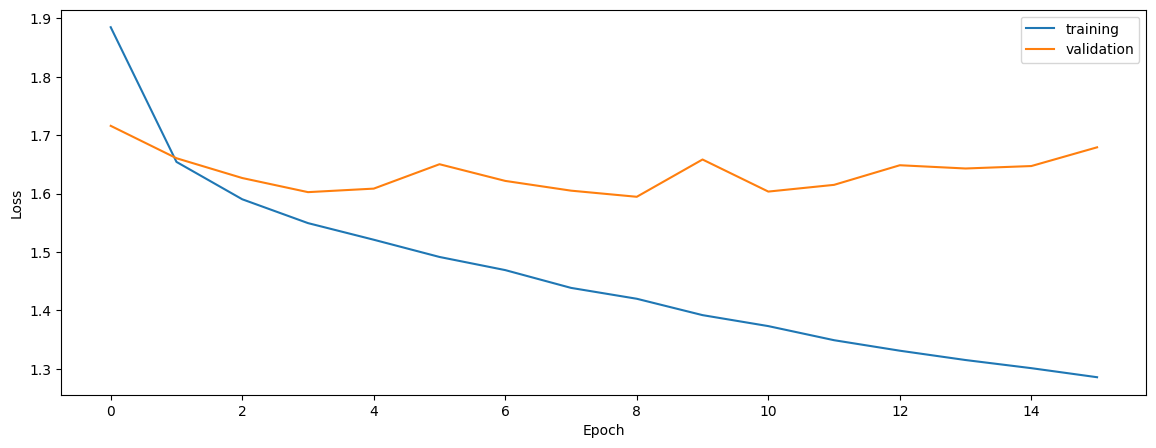

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.4683243717376369
0.40013438312974864
0.4186058244319961


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.4780165792075443
0.45219718158347677
0.44742812268225646


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.47879899744192655
0.4414126966662999
0.4533826037521319


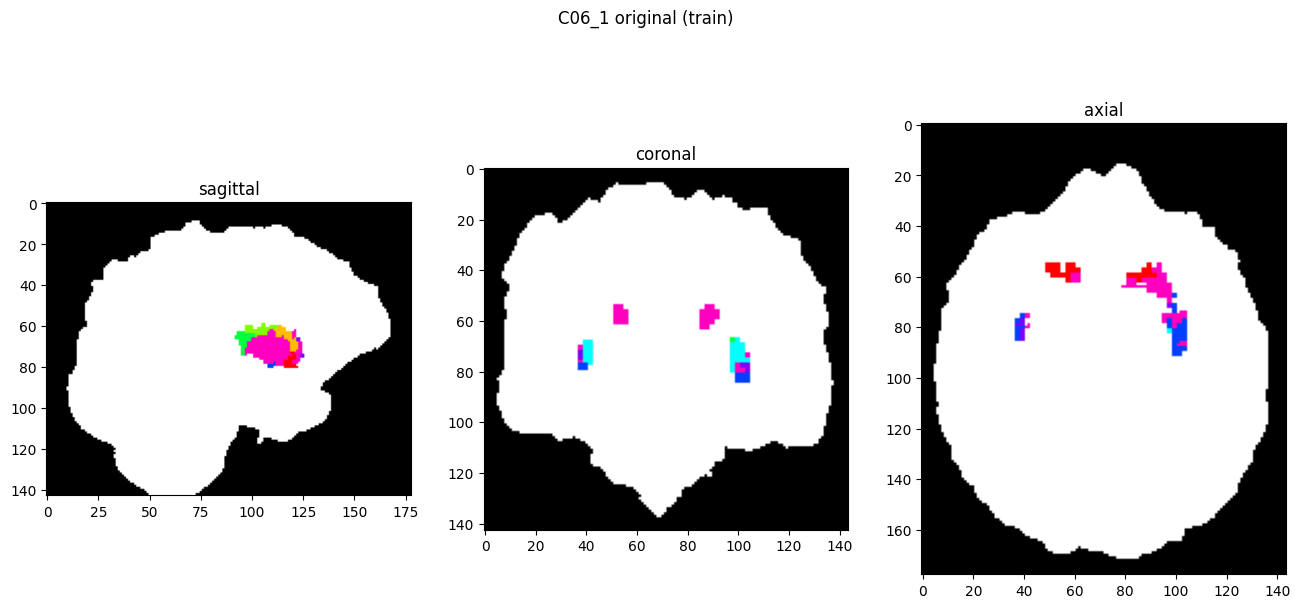

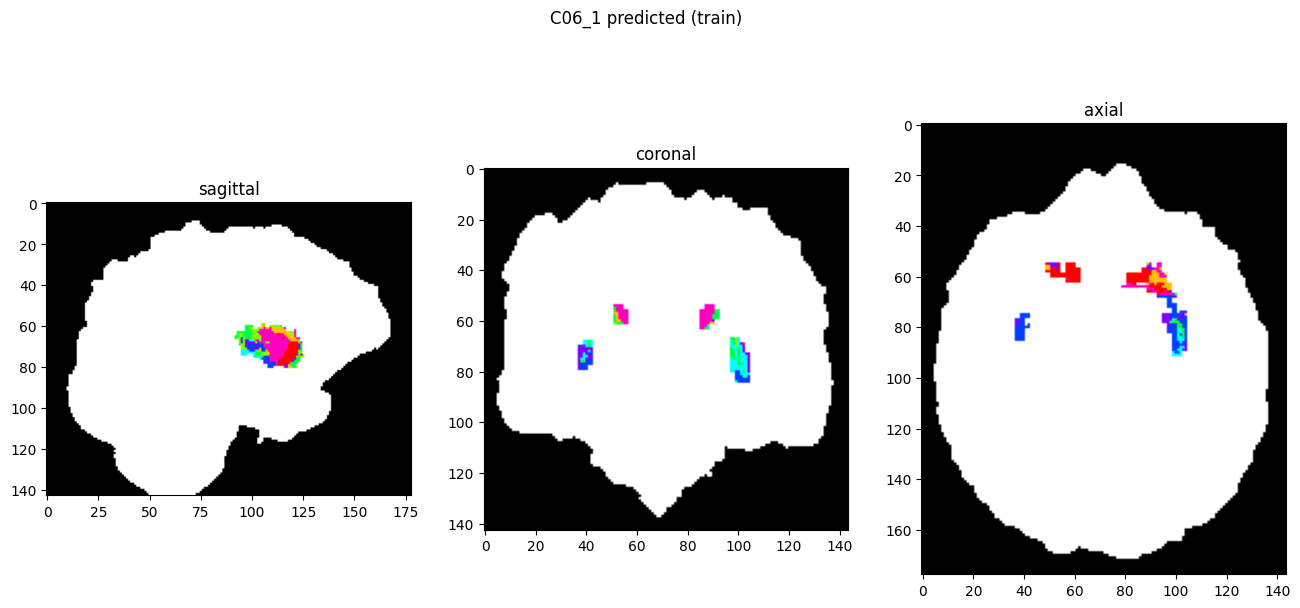

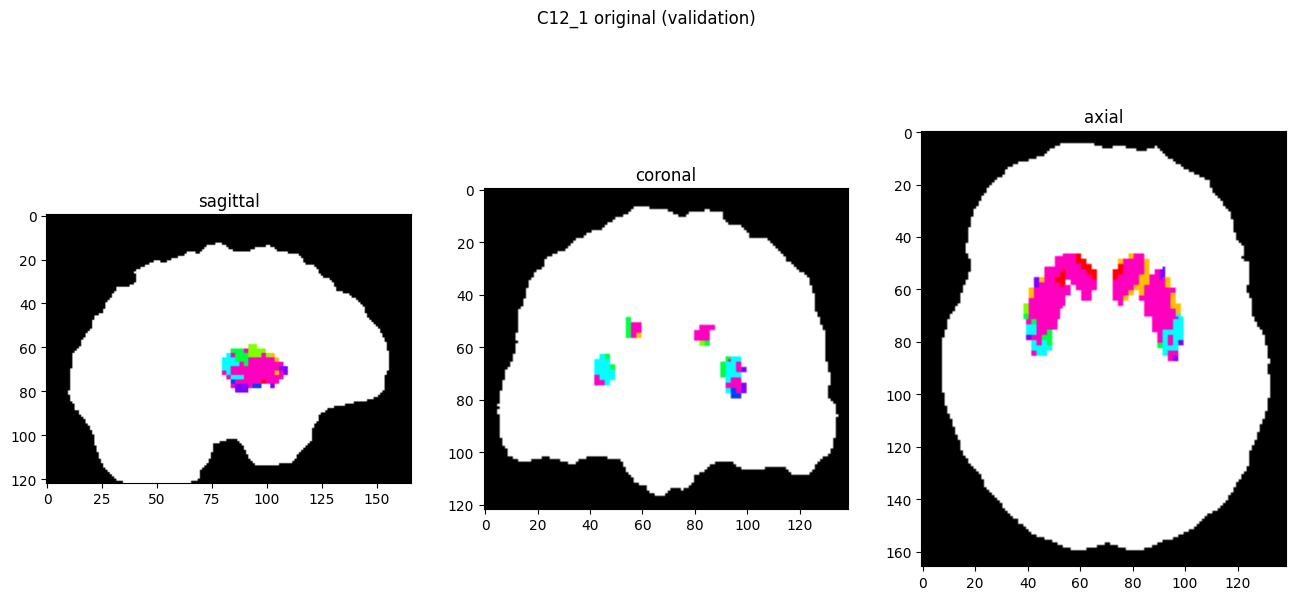

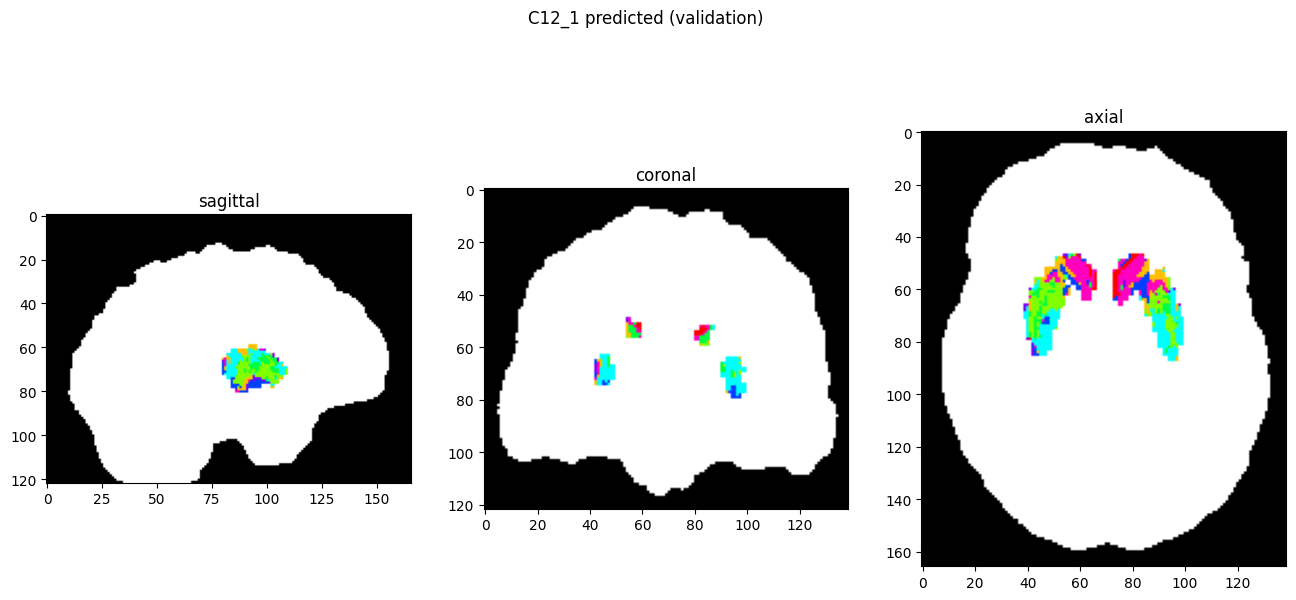

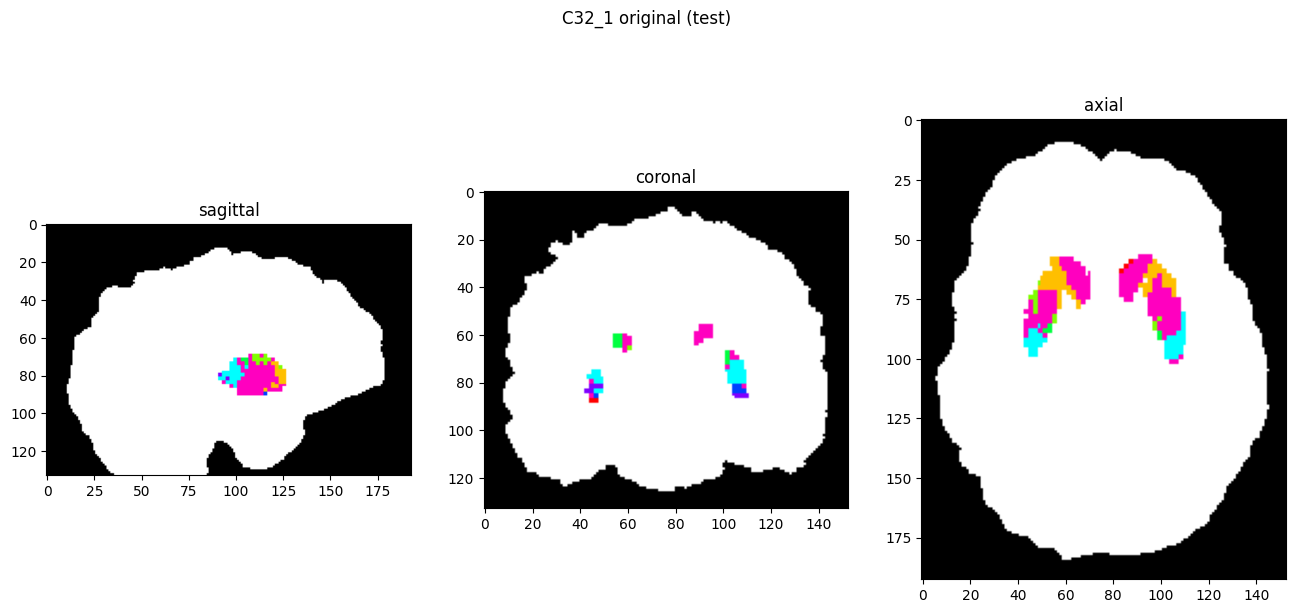

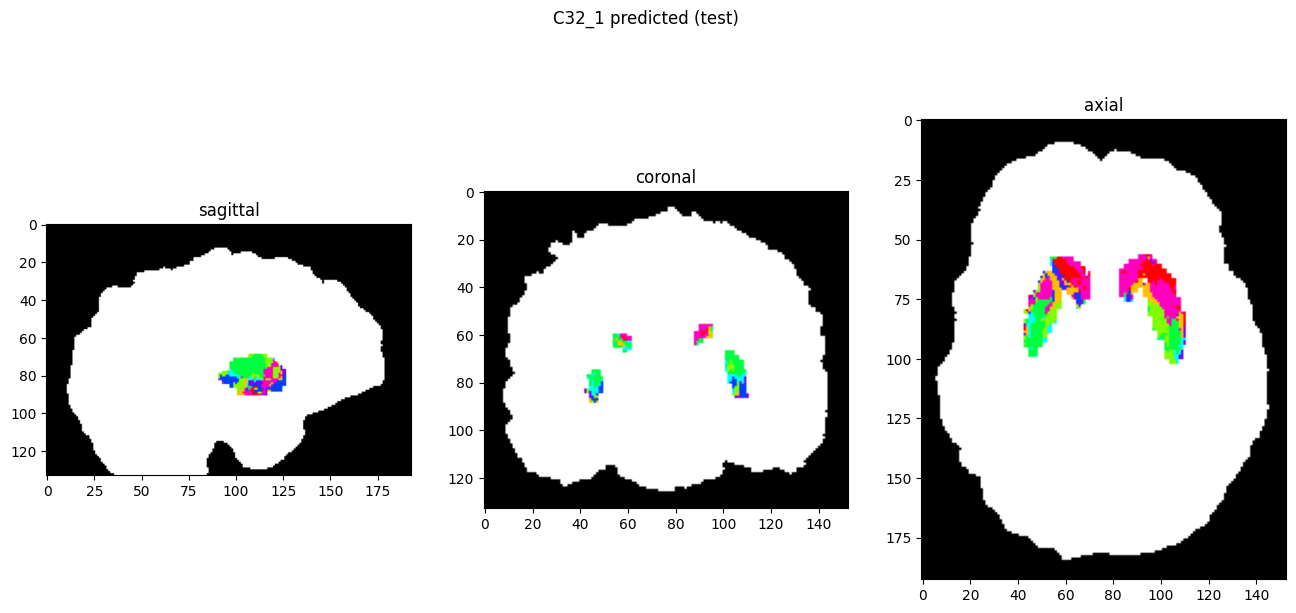

In [10]:
showResults(model, gen, threshold=0)